**Важные пояснения касательно дальнейших расчетов:**

1. В данной тетрадке приведены расчеты основных описатаельных статистик, а также вся визуализация Спецификаций, которая была использована в отчетном файле - расчеты спецификаций были произведены в среде Gretl при помощи МНК-оценок с использованием значений зависимой и независимых переменных из Excel-файла OLS.xlsx, где все сдвиги были рассчитаны "вручную" для получения наиболее корректных результатов (см. Приложение);

2. В спецификациях с наивными прогнозами (naïve forecasts) была применена фильтрация данных (то есть мы удалили все пропущенные значения, которые возникли ввиду сдвига согласно условиям спецификаций). Это привело к отличиям в фактическом уровне инфляции (baseline, с которой производится сравнение предсказанных значений) по сравнению с non-naïve forecasts;

3. В Python была построена тепловая карта для проведения сравнительного анализа всех спецификаций на основе метрик качества, рассчитанных в Gretl (№7);

4. В данной тетрадке была реализована визуализация для "единых графиков" прогнозов всех спецификаций (с разделением по naïve и non-naïve) в №8;

5. Вся работа, связанная с сезонностью, тоже была проведена в данной тетрадке (очистка датасета, расчет метрик качества, построение прогнозов и расчет ключевых метрик качества для построения non-seasonal тепловой карты) (№10).


ОПТИМИЗИРОВАННОСТЬ КОДА НЕ ГАРАНТИРУЕТСЯ #NOQA 

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS, add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import mode, skew
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [30]:
# Расчет основных описательных статистик (№2)

data = pd.read_excel('data.xlsx')

def calculate_statistics(dataframe):
    stats = []
    for col in dataframe.select_dtypes(include=['float64', 'int64']):
        col_data = dataframe[col]
        stats.append({
            'Metric': col,
            'Min': col_data.min(),
            'Max': col_data.max(),
            'Median': col_data.median(),
            'Mode': mode(col_data)[0][0],
            'Mean': col_data.mean(),
            'Std': col_data.std(),
            'Skewness': skew(col_data)
        })
    return pd.DataFrame(stats)

statistics_df = calculate_statistics(data)

print(statistics_df)

                    Metric            Min            Max         Median  \
0  HEADLINE_INFLATION_RATE      -0.833546       5.299968       1.416628   
1      CORE_INFLATION_RATE      -0.500101       4.966656       1.249868   
2       INFLATION_EXP_RATE      -0.700704       3.333290       1.564472   
3   SOTE_INDEX_GROWTH_RATE      -1.582545       1.489152       0.323699   
4           GDP_FACT_VALUE  228656.000000  413173.000000  307679.100000   
5          GDP_GROWTH_RATE     -28.887040      42.259454       4.171043   
6            GAP_OF_OUTPUT     -10.838054       3.743350       0.304834   

            Mode           Mean           Std  Skewness  
0       1.299967       1.592453      1.736274  0.331538  
1       0.966656       1.657010      1.605707  0.588969  
2       0.433322       1.535883      1.070706 -0.078637  
3      -1.582545       0.307198      0.433218 -1.820136  
4  228656.000000  312490.685000  53149.843250  0.312824  
5     -28.887040       3.977690      8.357046  0.29

In [31]:
# Расчет основных описательных статистик для разрыва выпуска (№2)

outgaps = [
    -0.277194, -0.488180, -0.841557, -0.929259, -0.442604, -0.038560,
    -0.016227, 0.458108, 1.142179, 0.871672, 1.816023, 1.484709,
    -0.322854, -0.275855, -0.146410, -0.924204, -0.544090, 0.211154,
    0.328356, 0.281313, 0.807073, 0.451843, 0.403511, 0.965947,
    -0.005599, -0.633612, -1.376657, -1.174889, -1.967107, -0.026325,
    0.079620, 0.491678, -0.080510, 0.097425, 0.772485, 1.241241,
    1.423913, 0.963703, 0.976046, 0.909456, 1.807470, 0.639221,
    0.910388, 0.805450, -1.911868, -10.838054, -3.642012, -2.357338,
    -3.230956, -0.682138, 0.344141, 3.743350, 2.254254, 2.473582,
    1.651242, 2.498313, 2.387809, 1.957243, 1.023826, -5.599508
]

data = {
    "Metric": ["OUTGAPS"],
    "Mode": [mode(outgaps)[0][0]],
    "Mean": [np.mean(outgaps)],
    "Min": [np.min(outgaps)],
    "Max": [np.max(outgaps)],
    "Median": [np.median(outgaps)],
    "Std": [np.std(outgaps)],
    "Skewness": [skew(outgaps)]
}

statistics_df = pd.DataFrame(data)

print(statistics_df)

    Metric       Mode      Mean        Min      Max    Median       Std  \
0  OUTGAPS -10.838054 -0.001664 -10.838054  3.74335  0.304835  2.082917   

   Skewness  
0 -2.608928  


**Спецификация 1:**

Проанализируем временной ряд данных об инфляции, создавая лаги (сдвиги данных на несколько шагов назад) и рассчитывая изменения между соседними лагами и текущими значениями, а также формируя целевую переменную как разницу между будущей инфляцией (сдвиг вперед) и текущим значением.
После обработки данных (удаления пропусков) мы формируем признаки для регрессии, включая дельты лагов. Линейная регрессионная модель обучается с использованием метода наименьших квадратов, оценивается с помощью метрик RMSE, MAE, R^2, F-Stat.
Результаты приведены на графике, где отображаются фактические и предсказанные значения инфляции.

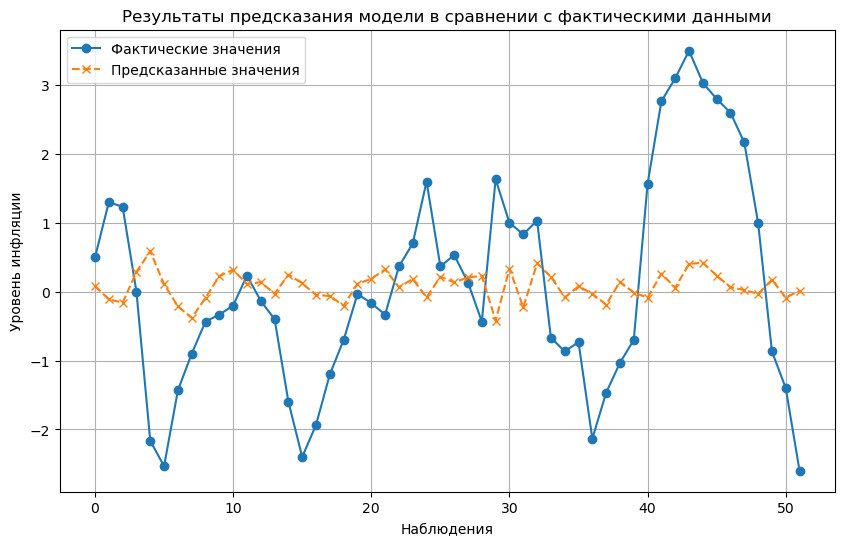

RMSE для Спецификации 1 (HEADLINE): 1.52
MAE для Спецификации 1 (HEADLINE): 1.23


In [37]:
# Спецификация 1 (HEADLINE) (№3)

data = pd.read_excel('data.xlsx')
processed_data = data.copy()

num_lags = 4
lagged_columns = [f'lag_{i}' for i in range(1, num_lags + 1)]

for index, col_name in enumerate(lagged_columns, start=1):
    processed_data[col_name] = processed_data['HEADLINE_INFLATION_RATE'].shift(index)

processed_data['current'] = processed_data['HEADLINE_INFLATION_RATE']

for i in range(1, num_lags):
    processed_data[f'delta_{i}'] = (
        processed_data[lagged_columns[i - 1]] - processed_data[lagged_columns[i]]
    )

processed_data['delta_current'] = (
    processed_data['current'] - processed_data['lag_1']
)

forward_lag = 4
processed_data['future'] = processed_data['HEADLINE_INFLATION_RATE'].shift(-forward_lag)
processed_data['target'] = processed_data['future'] - processed_data['HEADLINE_INFLATION_RATE']

final_data = processed_data.dropna()

target_variable = final_data['target']
feature_columns = [col for col in final_data.columns if 'delta' in col]
features = final_data[feature_columns]

regression_model = sm.OLS(target_variable, sm.add_constant(features)).fit()
predicted_values = regression_model.predict(sm.add_constant(features))

rmse = mean_squared_error(target_variable, predicted_values) ** 0.5
mae = mean_absolute_error(target_variable, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(target_variable.values, label='Фактические значения', linestyle='-', marker='o')
plt.plot(predicted_values.values, label='Предсказанные значения', linestyle='--', marker='x')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid(True)
plt.show()


print(f'RMSE для Спецификации 1 (HEADLINE): {rmse:.2f}')
print(f'MAE для Спецификации 1 (HEADLINE): {mae:.2f}')

**Спецификация 2:**

Прогнозируем временной ряд данных об инфляции данных за последние 4 периода, сдвинутых на один шаг вперед, для расчета прогнозных значений.
После очистки данных от пропусков вычисляем фактические и прогнозные значения, которые затем сравниваются с помощью метрик качества.
Построенный график позволяет нам сравнить фактические и прогнозные значения, позволяя оценить эффективность модели.

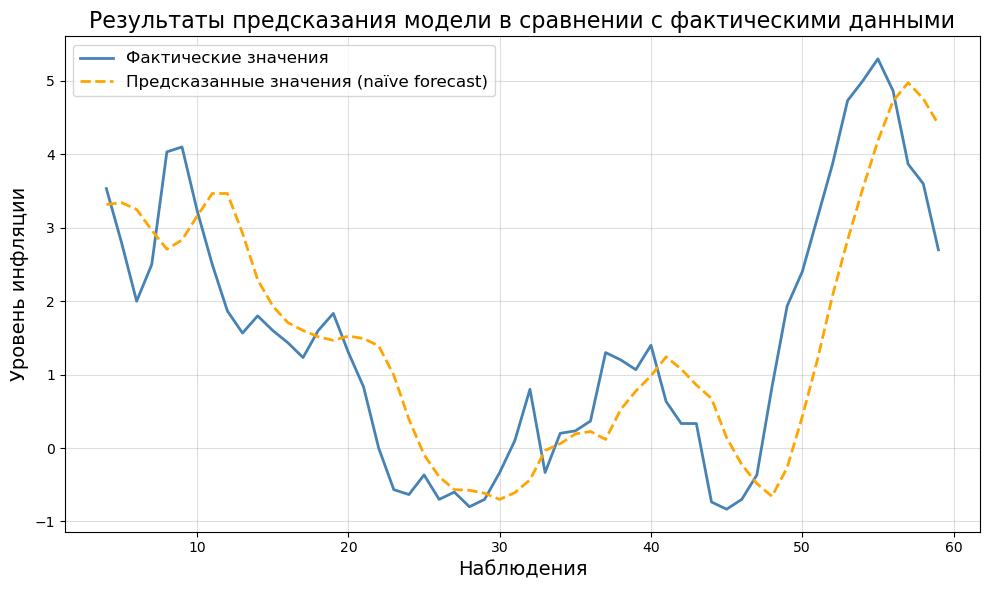

RMSE для Спецификации 2 (HEADLINE): 1.01
MAE для Спецификации 2 (HEADLINE): 0.81


In [36]:
# Спецификация 2 (HEADLINE) (№3) - naive forecast

df = pd.read_excel('data.xlsx')

forecast_data = df[['HEADLINE_INFLATION_RATE']].copy()

forecast_data['forecast'] = forecast_data['HEADLINE_INFLATION_RATE'].rolling(4).mean().shift(1)

filtered_data = forecast_data.dropna()

actual_values = filtered_data['HEADLINE_INFLATION_RATE']
predicted_values = filtered_data['forecast']

rmse = (mean_squared_error(actual_values, predicted_values)) ** 0.5
mae = mean_absolute_error(actual_values, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(predicted_values, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 2 (HEADLINE): {rmse:.2f}')
print(f'MAE для Спецификации 2 (HEADLINE): {mae:.2f}')

**Спецификация 1 (CORE_INFLATION):**

Выполняем анализ временного ряда базовой инфляции, создавая лаги и рассчитывая дельты — разности между соседними лагами и текущими значениями.
Затем формируем целевую переменную как разницу между значением инфляции через 4 шага вперед и текущим значением.
После удаления пропусков данные используются для построения линейной регрессионной модели, где признаки представлены дельтами, а целевая переменная — будущей разницей инфляции.
Строим график.

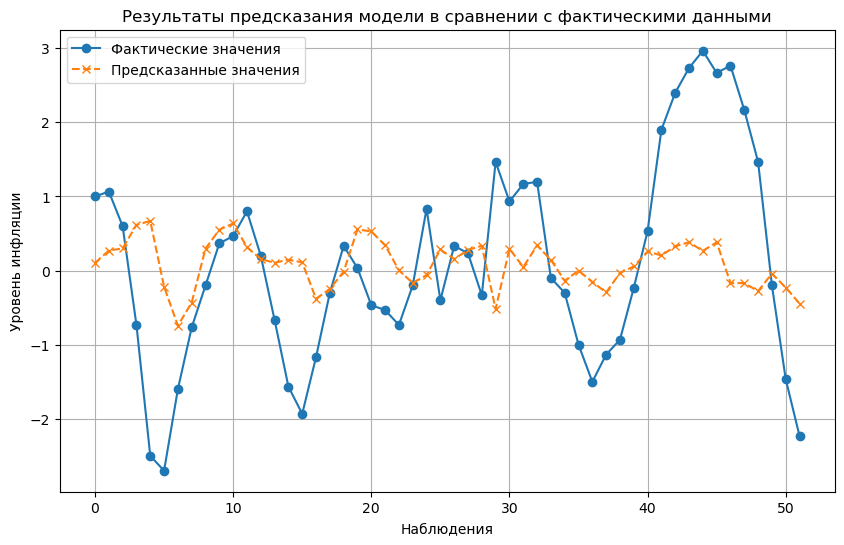

RMSE для спецификации 1 (CORE): 1.33
MAE для Спецификации 1 (CORE): 1.04


In [38]:
# Спецификация 1 (CORE_INFLATION) (№4)

data = pd.read_excel('data.xlsx')
processed_data = data.copy()

num_lags = 4
lagged_columns = [f'lag_{i}' for i in range(1, num_lags + 1)]

for index, col_name in enumerate(lagged_columns, start=1):
    processed_data[col_name] = processed_data['CORE_INFLATION_RATE'].shift(index)

processed_data['current'] = processed_data['CORE_INFLATION_RATE']

for i in range(1, num_lags):
    processed_data[f'delta_{i}'] = (
        processed_data[lagged_columns[i - 1]] - processed_data[lagged_columns[i]]
    )

processed_data['delta_current'] = (
    processed_data['current'] - processed_data['lag_1']
)

forward_lag = 4
processed_data['future'] = processed_data['CORE_INFLATION_RATE'].shift(-forward_lag)
processed_data['target'] = processed_data['future'] - processed_data['CORE_INFLATION_RATE']

final_data = processed_data.dropna()

target_variable = final_data['target']
feature_columns = [col for col in final_data.columns if 'delta' in col]
features = final_data[feature_columns]

regression_model = sm.OLS(target_variable, sm.add_constant(features)).fit()
predicted_values = regression_model.predict(sm.add_constant(features))

rmse = mean_squared_error(target_variable, predicted_values) ** 0.5
mae = mean_absolute_error(target_variable, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(target_variable.values, label='Фактические значения', linestyle='-', marker='o')
plt.plot(predicted_values.values, label='Предсказанные значения', linestyle='--', marker='x')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid(True)
plt.show()

print(f'RMSE для спецификации 1 (CORE): {rmse:.2f}')
print(f'MAE для Спецификации 1 (CORE): {mae:.2f}')

**Спецификация 2 (CORE_INFLATION):**

Производим прогнозирование временного ряда данных базовой инфляции с использованием данных за последние 4 периода, сдвинутых на один шаг вперед.
После удаления строк с пропущенными значениями формируются фактические значения базовой инфляции и прогнозные значения.
Строим график для визуального сравнения фактических и прогнозных значений, позволяющий наглядно оценить качество прогноза.

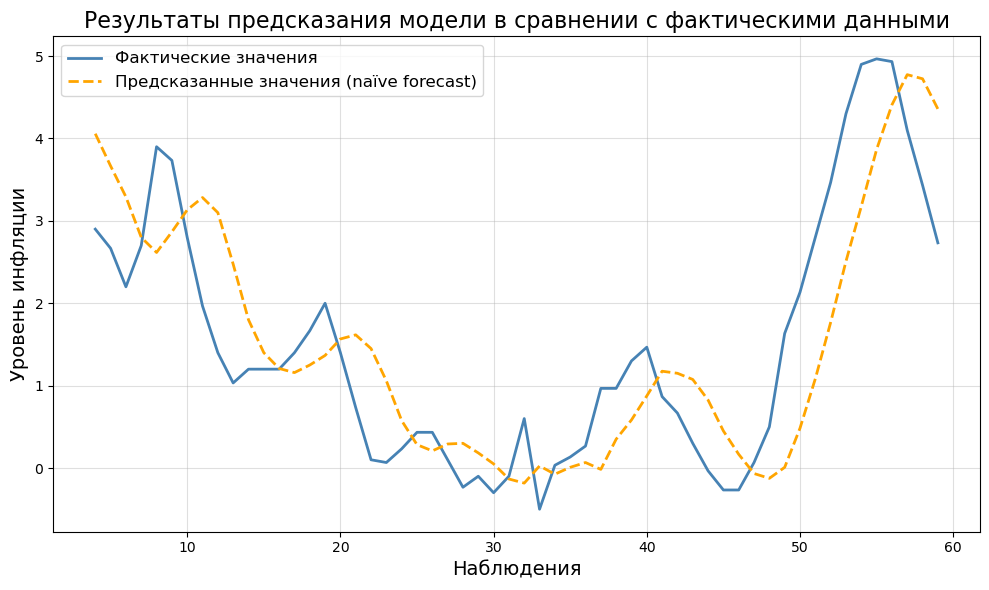

RMSE для Спецификации 2 (CORE): 0.92
MAE для Спецификации 2 (CORE): 0.76


In [39]:
# Спецификация 2 (CORE_INFLATION) (№4) - naive forecast

df = pd.read_excel('data.xlsx')

forecast_data = df[['CORE_INFLATION_RATE']].copy()

forecast_data['forecast'] = forecast_data['CORE_INFLATION_RATE'].rolling(4).mean().shift(1)

filtered_data = forecast_data.dropna()

actual_values = filtered_data['CORE_INFLATION_RATE']
predicted_values = filtered_data['forecast']

naive_rmse = (mean_squared_error(actual_values, predicted_values)) ** 0.5
naive_mae = mean_absolute_error(actual_values, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(predicted_values, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 2 (CORE): {naive_rmse:.2f}')
print(f'MAE для Спецификации 2 (CORE): {naive_mae:.2f}')

**Спецификация 3:**

Выполняем регрессионный анализ данных базовой инфляции, используя столбец pie_t+4 как независимую переменную для предсказания будущей инфляции pi_(t+4) через 4 периода.
В модель добавляется константа для учета смещения, после чего выполняется МНК для построения регрессии. Результаты включают коэффициенты модели, статистики и оценки значимости.
Строим график для визуального сравнения фактических и прогнозных значений инфляции.

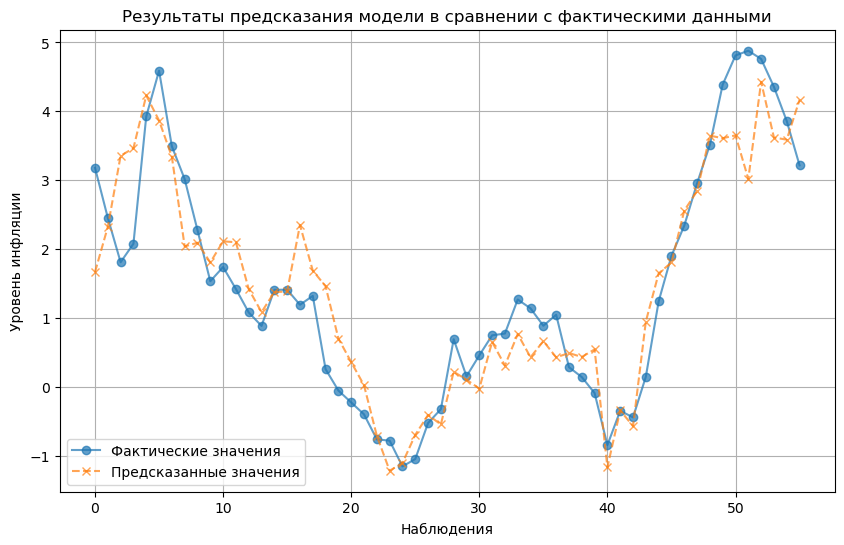

RMSE для Спецификации 3: 0.72
MAE для Спецификации 3: 0.59


In [40]:
# Спецификация 3 (№5) - в данном случае мы использовали значения зависимой и незаввисимой переменных,
# рассчитанные "вручную" в Excel

df_spec3 = pd.read_excel('spec3_gretl.xlsx')

y = df_spec3['pi_(t+4)']
X = df_spec3[['pie_t+4']]

X_with_const = sm.add_constant(X)

model = sm.OLS(y_spec3, X_with_const)
results = model.fit()

y_pred = results.predict(X_with_const)


rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_spec3.values, label='Фактические значения', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_spec3, label='Предсказанные значения', marker='x', linestyle='--', alpha=0.7)
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid()
plt.show()

print(f'RMSE для Спецификации 3: {rmse:.2f}')
print(f'MAE для Спецификации 3: {mae:.2f}')

**Спецификация 4:**

Выполняем прогнозирование будущей инфляции, рассчитывая скользящее среднее ожидаемой инфляции (INFLATION_EXP_RATE) за последние 4 периода, с последующим сдвигом на 4 шага вперед для формирования прогнозных значений (HEADLINE_INFLATION_FORECAST).
Строим график для визуального сравнения фактических значений инфляции и прогнозов. Итоговый вывод включает значения RMSE и MAE, отражающие точность модели в данной спецификации.

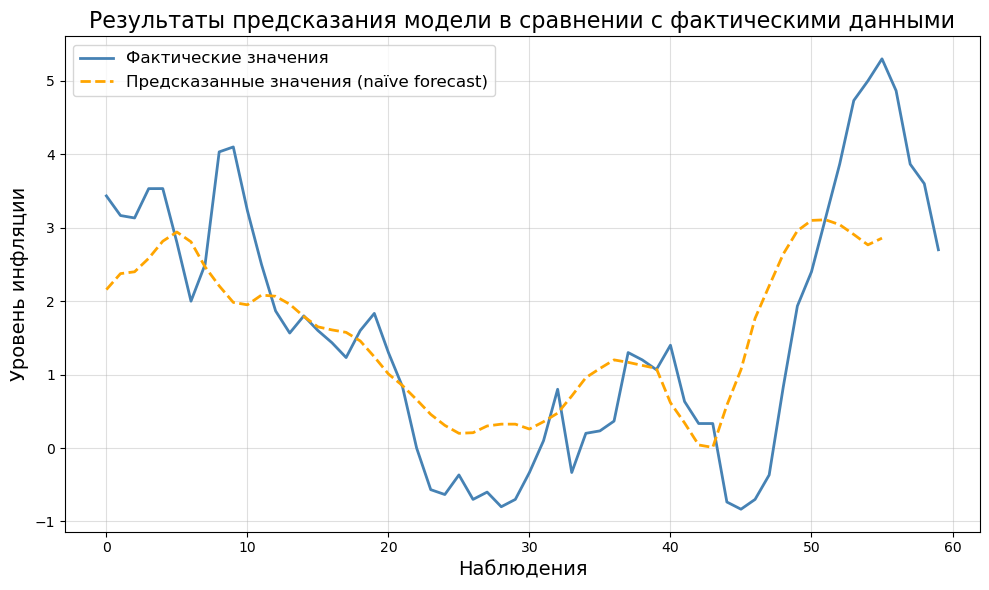

RMSE для Спецификации 4: 1.07
MAE для Спецификации 4: 0.82


In [41]:
# Спецификация 4 (№5) - naive forecast

df_original = pd.read_excel('data.xlsx')

df = df_original.copy()

df['ROLLING_INFL_EXP_GROWTH'] = df['INFLATION_EXP_RATE'].rolling(window=4).mean()

df['HEADLINE_INFLATION_FORECAST'] = df['ROLLING_INFL_EXP_GROWTH'].shift(-4)

actual = df['HEADLINE_INFLATION_RATE'].dropna()
forecast = df['HEADLINE_INFLATION_FORECAST'].dropna()

aligned_actual = actual.loc[forecast.index]
aligned_forecast = forecast.loc[aligned_actual.index]

mae = mean_absolute_error(aligned_actual, aligned_forecast)
rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(forecast, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 4: {rmse:.2f}')
print(f'MAE для Спецификации 4: {mae:.2f}')

**Спецификация 5:**

Выполняем анализ временного ряда инфляции, создавая лаги текущей инфляции (pi_t).
Вычисляем дельты между текущими и лагированными значениями, а также между будущей инфляцией (pi_t+4) и текущей. Формируем данные для регрессии, включающие эти дельты и переменную разрыва выпуска (GAP_OF_OUTPUT).
Строим линейную регрессионную модель методом OLS для предсказания изменений будущей инфляции (pi_t+4_minus_pi_t) на основе дельт и макроэкономического фактора.
Строим график для визуального сравнения фактических и прогнозных значений.

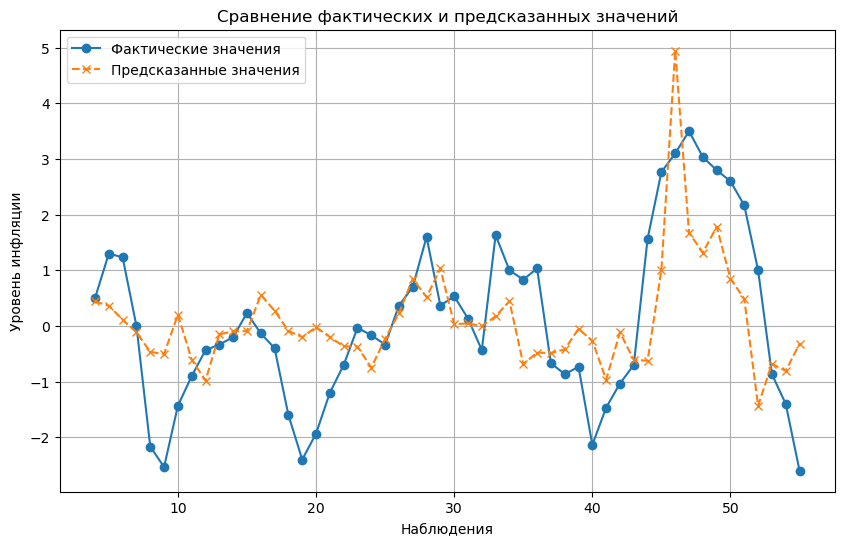

RMSE для Спецификации 5: 1.21
MAE для Спецификации 5: 0.97


In [43]:
# Спецификация 5 (№6)

original_df = pd.read_excel('data.xlsx')

df = original_df.copy()

df['pi_t'] = df['HEADLINE_INFLATION_RATE']
df['pi_t-1'] = df['pi_t'].shift(1)
df['pi_t-2'] = df['pi_t'].shift(2)
df['pi_t-3'] = df['pi_t'].shift(3)
df['pi_t-4'] = df['pi_t'].shift(4)

df['pi_t - pi_t-1'] = df['pi_t'] - df['pi_t-1']
df['pi_t-1 - pi_t-2'] = df['pi_t-1'] - df['pi_t-2']
df['pi_t-2 - pi_t-3'] = df['pi_t-2'] - df['pi_t-3']
df['pi_t-3 - pi_t-4'] = df['pi_t-3'] - df['pi_t-4']

df['xt-1'] = df['GAP_OF_OUTPUT'].shift(1)

df_clean = df.dropna()

df_clean['pi_t+4'] = df_clean['pi_t'].shift(-4)
df_clean['pi_t+4 - pi_t'] = df_clean['pi_t+4'] - df_clean['pi_t']

df_clean = df_clean.dropna(subset=['pi_t+4 - pi_t'])

X = df_clean[['pi_t - pi_t-1', 'pi_t-1 - pi_t-2', 'pi_t-2 - pi_t-3', 'pi_t-3 - pi_t-4', 'xt-1']]
y = df_clean['pi_t+4 - pi_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

r_squared = results.rsquared
rmse = np.sqrt(mean_squared_error(y, results.fittedvalues))
mae = mean_absolute_error(y, results.fittedvalues)
f_stat = results.fvalue

y_actual = y
y_predicted = results.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Фактические значения', marker='o', linestyle='-')
plt.plot(y_actual.index, y_predicted, label='Предсказанные значения', marker='x', linestyle='--')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

print(f'RMSE для Спецификации 5: {rmse:.2f}')
print(f'MAE для Спецификации 5: {mae:.2f}')

**Спецификация 6:**

Выполняем анализ временного ряда инфляции, создавая лаги текущей инфляции (pi_t), а также включаем лагированную переменную роста ВВП (GDP_GROWTH_RATE) как независимую переменную (x_t-1).
Рассчитываем изменения между текущими и лагированными значениями инфляции, а также между будущей инфляцией (pi_t+4) и текущей (pi_t).
На основе этих данных формируется набор для регрессии, где целевая переменная — изменение будущей инфляции (pi_t+4_minus_pi_t), а независимые переменные — дельты инфляции и лагированная переменная роста ВВП.
Результат - линейная регрессионная модель методом МНК.
Визуализируем фактические и прогнозные значения на графике.

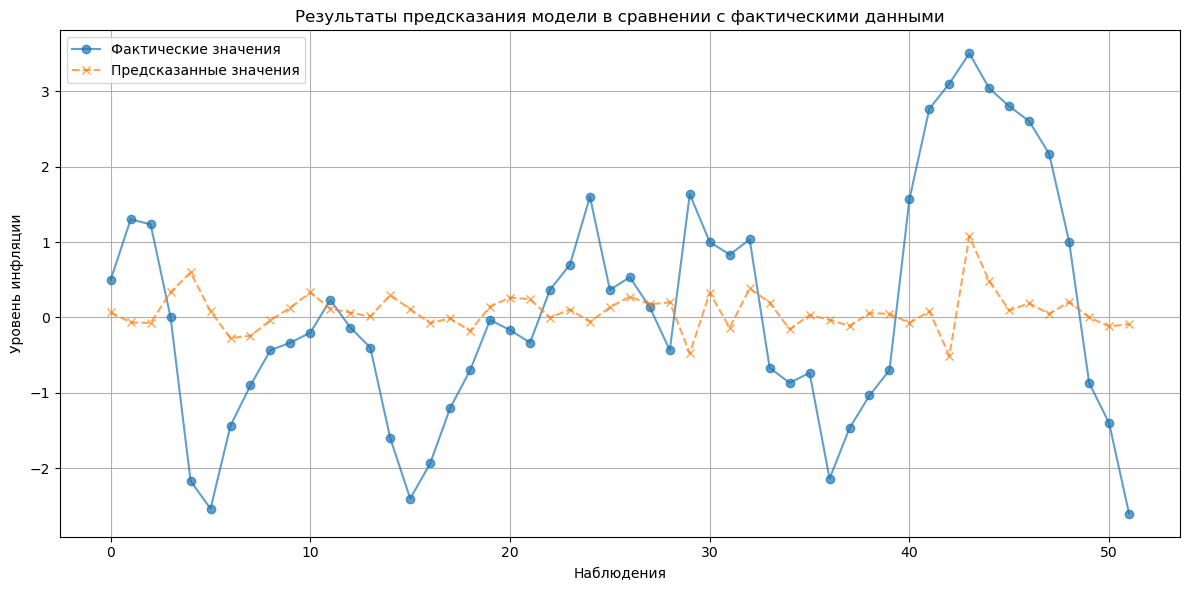

RMSE для Спецификации 6: 1.51
MAE для Спецификации 6: 1.22


In [46]:
# Спецификация 6 (№6)

df = pd.read_excel('data.xlsx')

df_copy = df.copy()

df_copy['pi_t'] = df_copy['HEADLINE_INFLATION_RATE']
df_copy['pi_t+4'] = df_copy['pi_t'].shift(-4)
df_copy['pi_t-1'] = df_copy['pi_t'].shift(1)
df_copy['pi_t-2'] = df_copy['pi_t'].shift(2)
df_copy['pi_t-3'] = df_copy['pi_t'].shift(3)
df_copy['pi_t-4'] = df_copy['pi_t'].shift(4)

df_copy['pi_t+4_minus_pi_t'] = df_copy['pi_t+4'] - df_copy['pi_t']
df_copy['pi_t_minus_pi_t-1'] = df_copy['pi_t'] - df_copy['pi_t-1']
df_copy['pi_t-1_minus_pi_t-2'] = df_copy['pi_t-1'] - df_copy['pi_t-2']
df_copy['pi_t-2_minus_pi_t-3'] = df_copy['pi_t-2'] - df_copy['pi_t-3']
df_copy['pi_t-3_minus_pi_t-4'] = df_copy['pi_t-3'] - df_copy['pi_t-4']

df_copy['x_t-1'] = df_copy['GDP_GROWTH_RATE'].shift(1)

regression_data = df_copy[['pi_t+4_minus_pi_t', 'pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                               'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']].dropna()

y = regression_data['pi_t+4_minus_pi_t']
X = regression_data[['pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2', 
                             'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

y_pred = model.predict(X)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
mae = np.mean(np.abs(y - y_pred))

plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y.values, label='Фактические значения', marker='o', linestyle='-', alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label='Предсказанные значения', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 6: {rmse:.2f}')
print(f'MAE для Спецификации 6: {mae:.2f}')

**Спецификация 7:**

Выполняем прогнозирование изменения инфляции через 4 периода (HEADLINE_FUTURE_DIFF) на основе текущей разности инфляции (HEADLINE_DIFF), её лагов, а также лагированного значения темпа роста индекса SOTE (SOTE_LAG1).
После создания и обработки данных формируем набор для регрессии, где целевая переменная (y) — это будущая разность инфляции, а независимые переменные (X) включают текущие и лагированные показатели.
Строим линейную модель, итоговый результат фактических значений и предсказанных визуализируем.

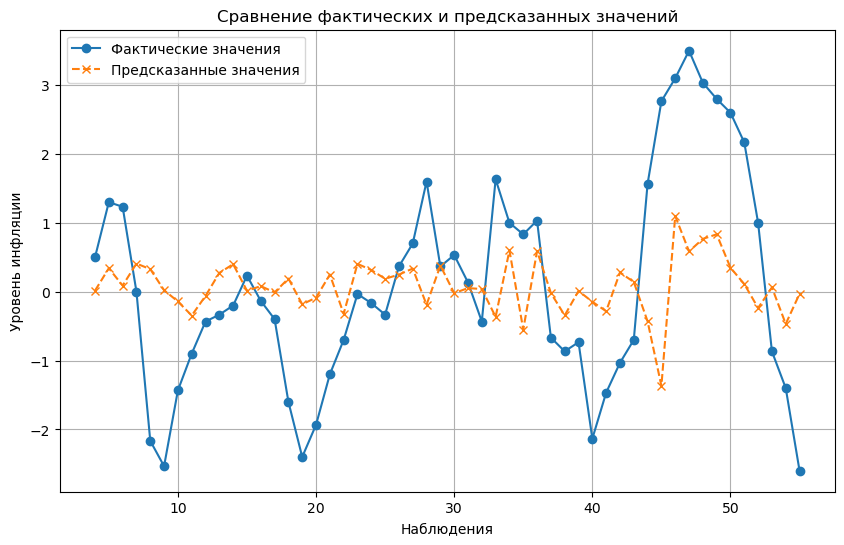

RMSE для Спецификации 7: 1.48
MAE для Спецификации 7: 1.18


In [47]:
# Спецификация 7 (№ 6)

original_df = pd.read_excel('data.xlsx')

df = original_df.copy()

df['pi_t'] = df['HEADLINE_INFLATION_RATE']
df['pi_t-1'] = df['pi_t'].shift(1)
df['pi_t-2'] = df['pi_t'].shift(2)
df['pi_t-3'] = df['pi_t'].shift(3)
df['pi_t-4'] = df['pi_t'].shift(4)

df['pi_t - pi_t-1'] = df['pi_t'] - df['pi_t-1']
df['pi_t-1 - pi_t-2'] = df['pi_t-1'] - df['pi_t-2']
df['pi_t-2 - pi_t-3'] = df['pi_t-2'] - df['pi_t-3']
df['pi_t-3 - pi_t-4'] = df['pi_t-3'] - df['pi_t-4']

df['xt-1'] = df['SOTE_INDEX_GROWTH_RATE'].shift(1)

df_clean = df.dropna()

df_clean['pi_t+4'] = df_clean['pi_t'].shift(-4)
df_clean['pi_t+4 - pi_t'] = df_clean['pi_t+4'] - df_clean['pi_t']

df_clean = df_clean.dropna(subset=['pi_t+4 - pi_t'])

X = df_clean[['pi_t - pi_t-1', 'pi_t-1 - pi_t-2', 'pi_t-2 - pi_t-3', 'pi_t-3 - pi_t-4', 'xt-1']]
y = df_clean['pi_t+4 - pi_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

r_squared = results.rsquared
rmse = np.sqrt(mean_squared_error(y, results.fittedvalues))
mae = mean_absolute_error(y, results.fittedvalues)
f_stat = results.fvalue

y_actual = y
y_predicted = results.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Фактические значения', marker='o', linestyle='-')
plt.plot(y_actual.index, y_predicted, label='Предсказанные значения', marker='x', linestyle='--')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

print(f'RMSE для Спецификации 7: {rmse:.2f}')
print(f'MAE для Спецификации 7: {mae:.2f}')

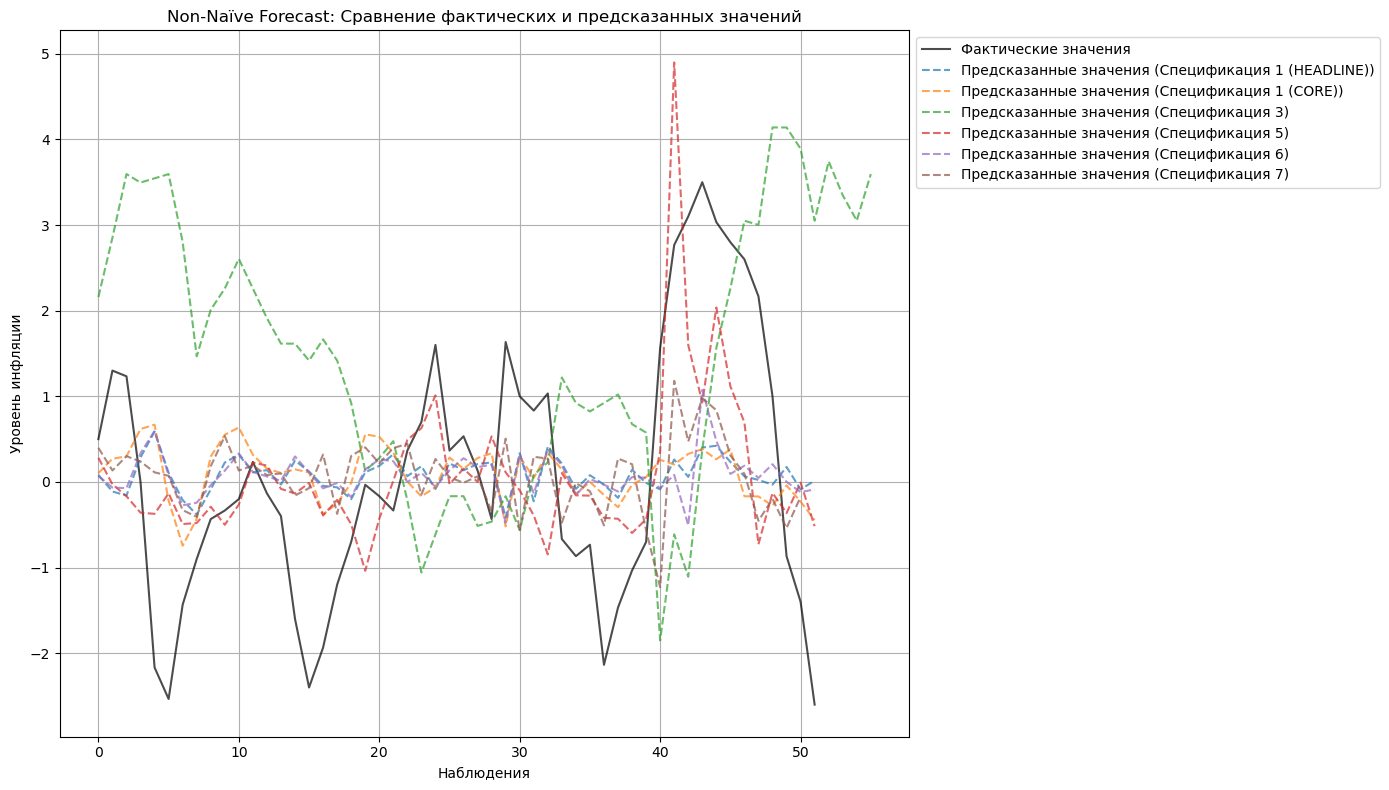

In [48]:
# Единый график для всех спецификаций в Non-Naïve Forecast (№7)

df = pd.read_excel('data.xlsx')

def calculate_specification(data, inflation_column, lags=4, forward_lag=4):
    processed_data = data.copy()
    lagged_columns = [f'lag_{i}' for i in range(1, lags + 1)]
    for index, col_name in enumerate(lagged_columns, start=1):
        processed_data[col_name] = processed_data[inflation_column].shift(index)
    processed_data['current'] = processed_data[inflation_column]
    for i in range(1, lags):
        processed_data[f'delta_{i}'] = (
            processed_data[lagged_columns[i - 1]] - processed_data[lagged_columns[i]]
        )
    processed_data['delta_current'] = processed_data['current'] - processed_data['lag_1']
    processed_data['future'] = processed_data[inflation_column].shift(-forward_lag)
    processed_data['target'] = processed_data['future'] - processed_data[inflation_column]
    final_data = processed_data.dropna()
    target_variable = final_data['target']
    feature_columns = [col for col in final_data.columns if 'delta' in col]
    features = final_data[feature_columns]
    regression_model = sm.OLS(target_variable, sm.add_constant(features)).fit()
    predicted_values = regression_model.predict(sm.add_constant(features))
    rmse = mean_squared_error(target_variable, predicted_values) ** 0.5
    mae = mean_absolute_error(target_variable, predicted_values)
    return regression_model, target_variable, predicted_values, rmse, mae

results = {}
model_1_headline, actual_1_headline, predicted_1_headline, rmse_1_headline, mae_1_headline = calculate_specification(df, 'HEADLINE_INFLATION_RATE')
results["Спецификация 1 (HEADLINE)"] = (model_1_headline, actual_1_headline, predicted_1_headline, rmse_1_headline, mae_1_headline)
model_1_core, actual_1_core, predicted_1_core, rmse_1_core, mae_1_core = calculate_specification(df, 'CORE_INFLATION_RATE')
results["Спецификация 1 (CORE)"] = (model_1_core, actual_1_core, predicted_1_core, rmse_1_core, mae_1_core)

spec3_data = pd.read_excel('spec3_gretl.xlsx')
y_spec3 = spec3_data['pi_(t+4)']
X_spec3 = spec3_data[['pie_t+4']]
X_spec3_with_const = sm.add_constant(X_spec3)
model_spec3 = sm.OLS(y_spec3, X_spec3_with_const).fit()
y_pred_spec3 = model_spec3.predict(X_spec3_with_const)
rmse_spec3 = mean_squared_error(y_spec3, y_pred_spec3) ** 0.5
mae_spec3 = mean_absolute_error(y_spec3, y_pred_spec3)
results["Спецификация 3"] = (model_spec3, y_spec3, y_pred_spec3, rmse_spec3, mae_spec3)

df['pi_t'] = df['HEADLINE_INFLATION_RATE']
df['pi_t+4'] = df['pi_t'].shift(-4)
df['pi_t-1'] = df['pi_t'].shift(1)
df['pi_t-2'] = df['pi_t'].shift(2)
df['pi_t-3'] = df['pi_t'].shift(3)
df['pi_t-4'] = df['pi_t'].shift(4)

df['pi_t+4_minus_pi_t'] = df['pi_t+4'] - df['pi_t']
df['pi_t_minus_pi_t-1'] = df['pi_t'] - df['pi_t-1']
df['pi_t-1_minus_pi_t-2'] = df['pi_t-1'] - df['pi_t-2']
df['pi_t-2_minus_pi_t-3'] = df['pi_t-2'] - df['pi_t-3']
df['pi_t-3_minus_pi_t-4'] = df['pi_t-3'] - df['pi_t-4']
regression_data_5 = df[['pi_t+4_minus_pi_t', 'pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                        'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'GAP_OF_OUTPUT']].dropna()
y_5 = regression_data_5['pi_t+4_minus_pi_t']
X_5 = regression_data_5[['pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                         'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'GAP_OF_OUTPUT']]
X_5 = sm.add_constant(X_5)
model_5 = sm.OLS(y_5, X_5).fit()
y_pred_5 = model_5.predict(X_5)
rmse_5 = mean_squared_error(y_5, y_pred_5) ** 0.5
mae_5 = mean_absolute_error(y_5, y_pred_5)
results["Спецификация 5"] = (model_5, y_5, y_pred_5, rmse_5, mae_5)

df['x_t-1'] = df['GDP_GROWTH_RATE'].shift(1)
regression_data_6 = df[['pi_t+4_minus_pi_t', 'pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                        'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']].dropna()
y_6 = regression_data_6['pi_t+4_minus_pi_t']
X_6 = regression_data_6[['pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                         'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']]
X_6 = sm.add_constant(X_6)
model_6 = sm.OLS(y_6, X_6).fit()
y_pred_6 = model_6.predict(X_6)
rmse_6 = mean_squared_error(y_6, y_pred_6) ** 0.5
mae_6 = mean_absolute_error(y_6, y_pred_6)
results["Спецификация 6"] = (model_6, y_6, y_pred_6, rmse_6, mae_6)

df['HEADLINE_DIFF'] = df['HEADLINE_INFLATION_RATE'].diff()
for lag in range(1, 5):
    df[f'HEADLINE_LAG{lag}'] = df['HEADLINE_DIFF'].shift(lag)
df['SOTE_LAG1'] = df['SOTE_INDEX_GROWTH_RATE'].shift(1)
df['HEADLINE_FUTURE_DIFF'] = df['HEADLINE_INFLATION_RATE'].shift(-4) - df['HEADLINE_INFLATION_RATE']
model_data_7 = df.dropna(subset=[
    'HEADLINE_FUTURE_DIFF',
    'HEADLINE_DIFF',
    'HEADLINE_LAG1',
    'HEADLINE_LAG2',
    'HEADLINE_LAG3',
    'HEADLINE_LAG4',
    'SOTE_LAG1'
])
y_7 = model_data_7['HEADLINE_FUTURE_DIFF']
X_7 = model_data_7[['HEADLINE_DIFF', 'HEADLINE_LAG1', 'HEADLINE_LAG2', 
                    'HEADLINE_LAG3', 'HEADLINE_LAG4', 'SOTE_LAG1']]
X_7 = sm.add_constant(X_7)
model_7 = sm.OLS(y_7, X_7).fit()
y_pred_7 = model_7.predict(X_7)
rmse_7 = mean_squared_error(y_7, y_pred_7) ** 0.5
mae_7 = mean_absolute_error(y_7, y_pred_7)
results["Спецификация 7"] = (model_7, y_7, y_pred_7, rmse_7, mae_7)

plt.figure(figsize=(14, 8))

plt.plot(results["Спецификация 1 (HEADLINE)"][1].values, label="Фактические значения", linestyle='-', color='black', alpha=0.7)

for spec_name in results.keys():
    _, _, predicted, _, _ = results[spec_name]
    plt.plot(predicted.values, label=f"Предсказанные значения ({spec_name})", linestyle='--', alpha=0.7)

plt.title("Non-Naïve Forecast: Сравнение фактических и предсказанных значений")
plt.xlabel("Наблюдения")
plt.ylabel("Уровень инфляции")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

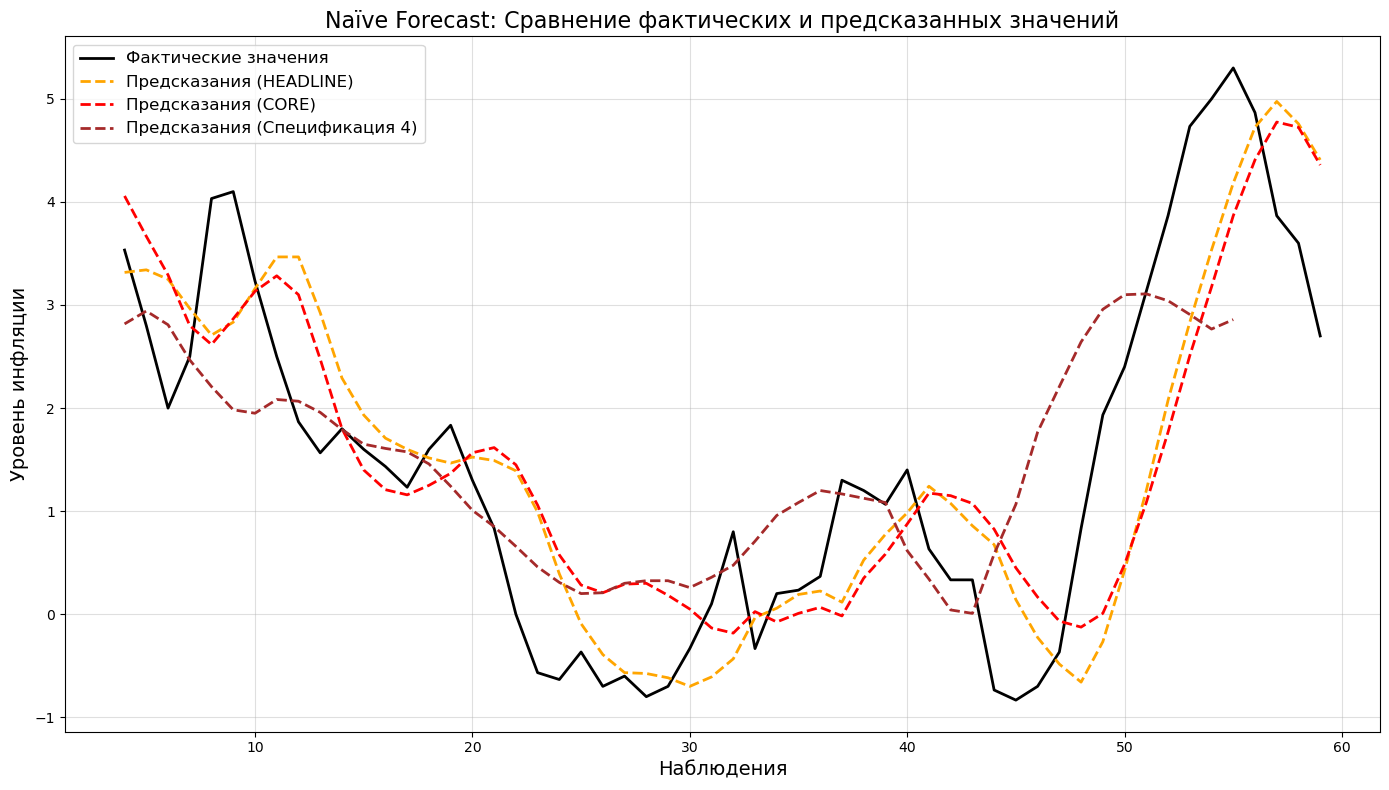

In [54]:
# Единый график для всех спецификаций в Naïve Forecast (№7)

data = pd.read_excel('data.xlsx')

df = data.copy()

forecast_data_headline = df[['HEADLINE_INFLATION_RATE']].copy()
forecast_data_headline['forecast'] = forecast_data_headline['HEADLINE_INFLATION_RATE'].rolling(4).mean().shift(1)
filtered_data_headline = forecast_data_headline.dropna()

actual_values_headline = filtered_data_headline['HEADLINE_INFLATION_RATE']
predicted_values_headline = filtered_data_headline['forecast']

common_index_spec4 = actual_values_headline.index.intersection(predicted_values_spec4.index)
aligned_actual_spec4 = actual_values_headline.loc[common_index_spec4]
aligned_forecast_spec4 = predicted_values_spec4.loc[common_index_spec4]

naive_rmse_spec4 = mean_squared_error(aligned_actual_spec4, aligned_forecast_spec4) ** 0.5
naive_mae_spec4 = mean_absolute_error(aligned_actual_spec4, aligned_forecast_spec4)

plt.figure(figsize=(14, 8))

plt.plot(actual_values_headline, label='Фактические значения', linewidth=2, color='black')

plt.plot(predicted_values_headline, label='Предсказания (HEADLINE)', linestyle='--', linewidth=2, color='orange')
plt.plot(predicted_values_core, label='Предсказания (CORE)', linestyle='--', linewidth=2, color='red')
plt.plot(aligned_forecast_spec4, label='Предсказания (Спецификация 4)', linestyle='--', linewidth=2, color='brown')

plt.title('Naïve Forecast: Сравнение фактических и предсказанных значений', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

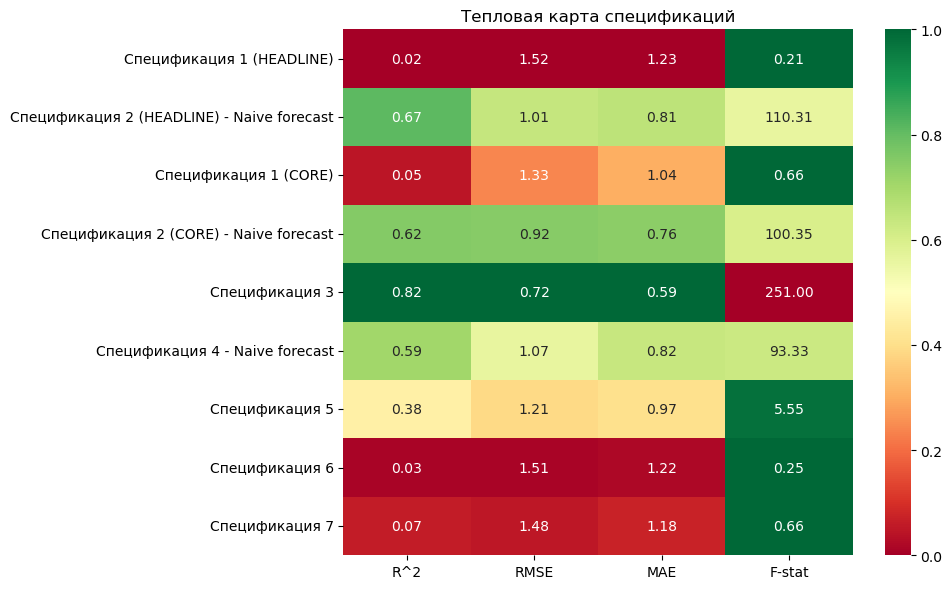

In [55]:
# Сравнительный анализ спецификаций (№7)

data = {
    "Specification": [
        "Спецификация 1 (HEADLINE)",
        "Спецификация 2 (HEADLINE) - Naive forecast",
        "Спецификация 1 (CORE)",
        "Спецификация 2 (CORE) - Naive forecast",
        "Спецификация 3",
        "Спецификация 4 - Naive forecast",
        "Спецификация 5",
        "Спецификация 6",
        "Спецификация 7",
    ],
    "R^2": [0.018, 0.671, 0.053, 0.6239, 0.823, 0.5861, 0.38, 0.027, 0.0665],
    "RMSE": [
        1.5180754790525988,
        1.01,
        1.328143793776217,
        0.9229,
        0.7223,
        1.0716,
        1.2096,
        1.5111332042549823,
        1.4798,
    ],
    "MAE": [
        1.2296687031618925,
        0.81,
        1.03619153765564,
        0.7553,
        0.5895,
        0.8245,
        0.97053,
        1.2180488037635215,
        1.1833,
    ],
    "F-stat": [0.2111, 110.31, 0.6600, 100.35, 251.0, 93.33, 5.55, 0.2515, 0.655],
}

df = pd.DataFrame(data)

normalized_df = df.drop(columns=["Specification"])
normalized_df = (normalized_df - normalized_df.min()) / (normalized_df.max() - normalized_df.min())

adjusted_df = normalized_df.copy()
adjusted_df["RMSE"] = 1 - normalized_df["RMSE"]
adjusted_df["MAE"] = 1 - normalized_df["MAE"]
adjusted_df["F-stat"] = 1 - normalized_df["F-stat"]

plt.figure(figsize=(10, 6))
sns.heatmap(adjusted_df, annot=df.drop(columns=["Specification"]), cmap="RdYlGn", cbar=True, fmt=".2f")
plt.title("Тепловая карта спецификаций")
plt.yticks(np.arange(len(df)) + 0.5, df["Specification"], rotation=0)
plt.tight_layout()
plt.show()
plt.show()

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**ОТСЮДА НАЧИНАЕТСЯ БЛОК ПО РАБОТЕ С ДАННЫМИ, ОЧИЩЕННЫМИ ОТ СЕЗОНАЛЬНОСТИ**

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Processing column: HEADLINE_INFLATION_RATE


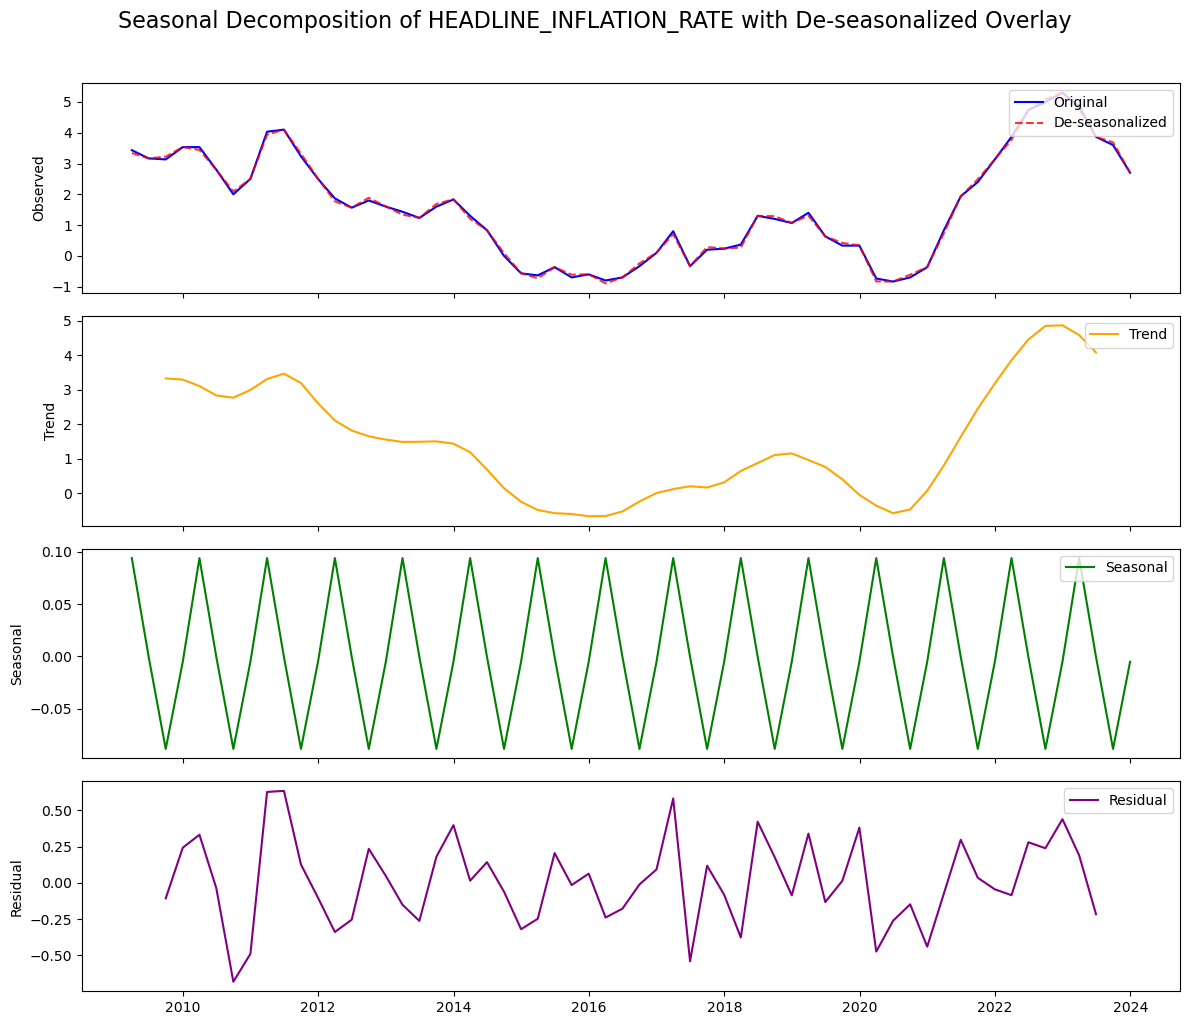

ADF Test for HEADLINE_INFLATION_RATE:
  Test Statistic: -2.409843249933555
  p-value: 0.1389774758193158
  Critical Values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
  HEADLINE_INFLATION_RATE is not stationary. Applying first difference...


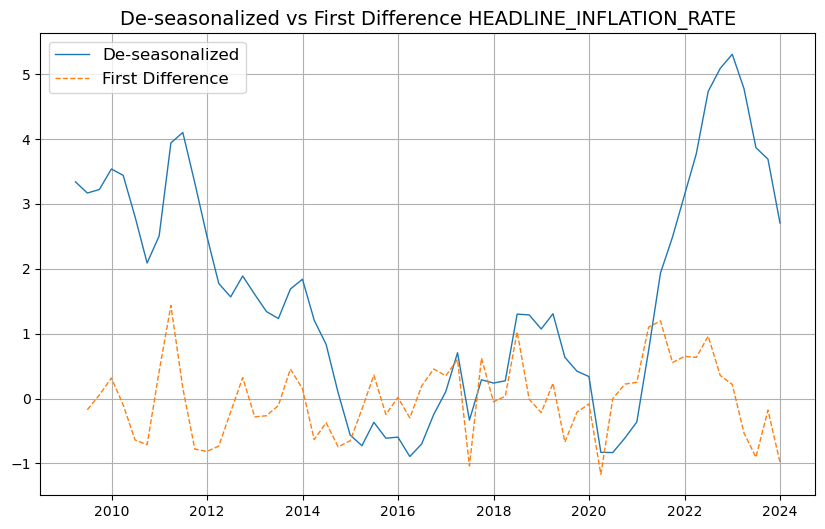

  ADF Test after differencing:
    Test Statistic: -3.613266898544888
    p-value: 0.00551240013878696
    Critical Values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}

--------------------------------------------------

Processing column: CORE_INFLATION_RATE


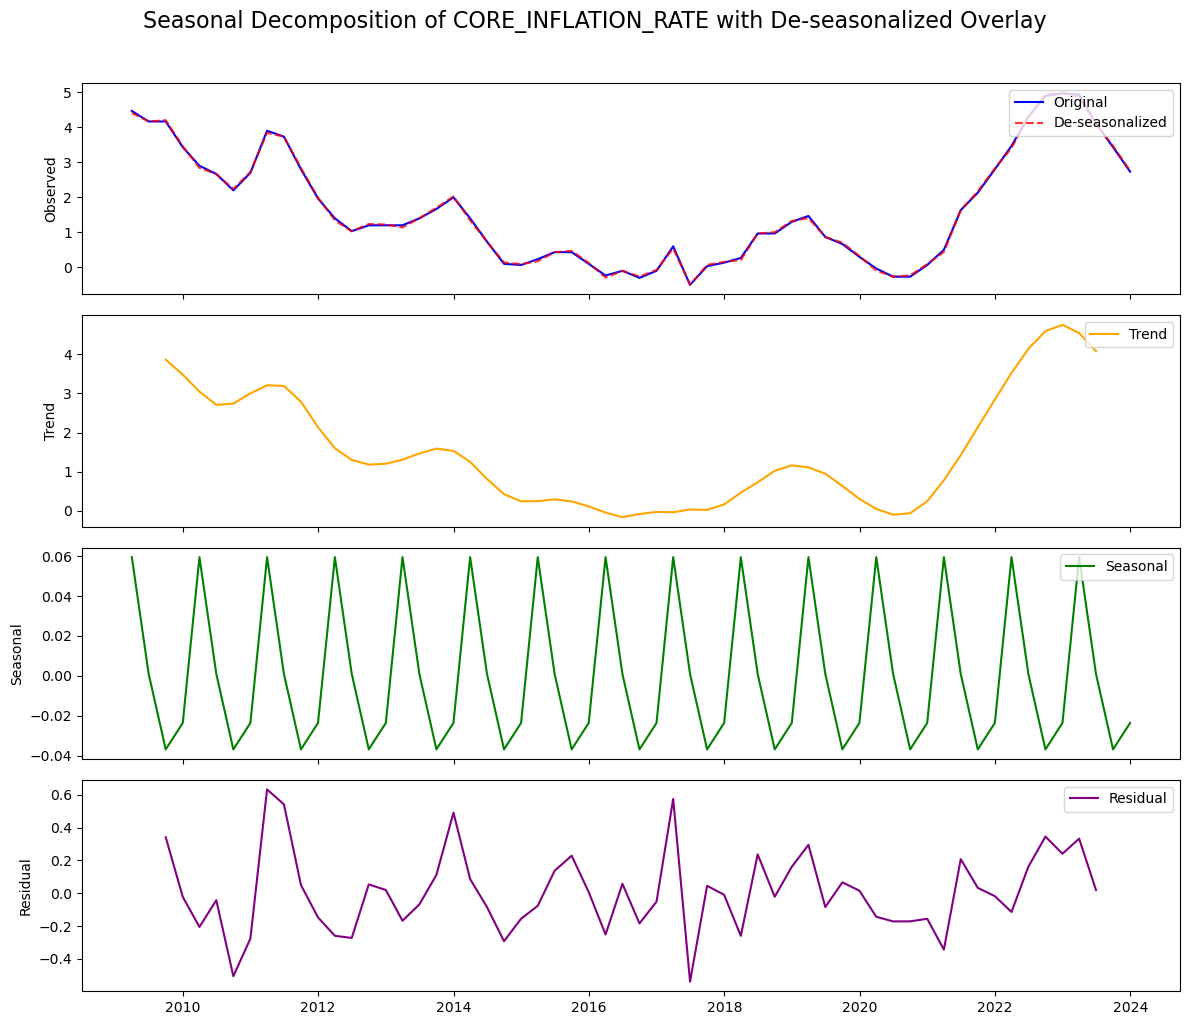

ADF Test for CORE_INFLATION_RATE:
  Test Statistic: -1.9062150588143583
  p-value: 0.32914302337361856
  Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
  CORE_INFLATION_RATE is not stationary. Applying first difference...


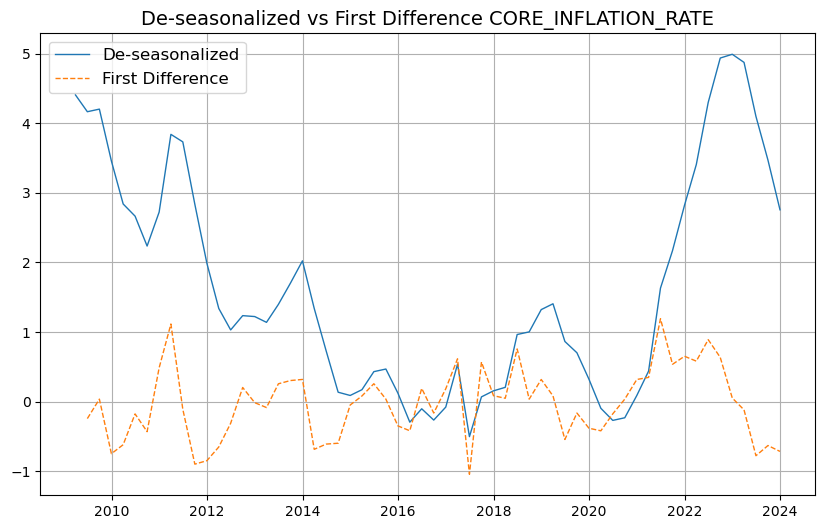

  ADF Test after differencing:
    Test Statistic: -4.3907521597715125
    p-value: 0.00030822072908611695
    Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}

--------------------------------------------------

Processing column: INFLATION_EXP_RATE


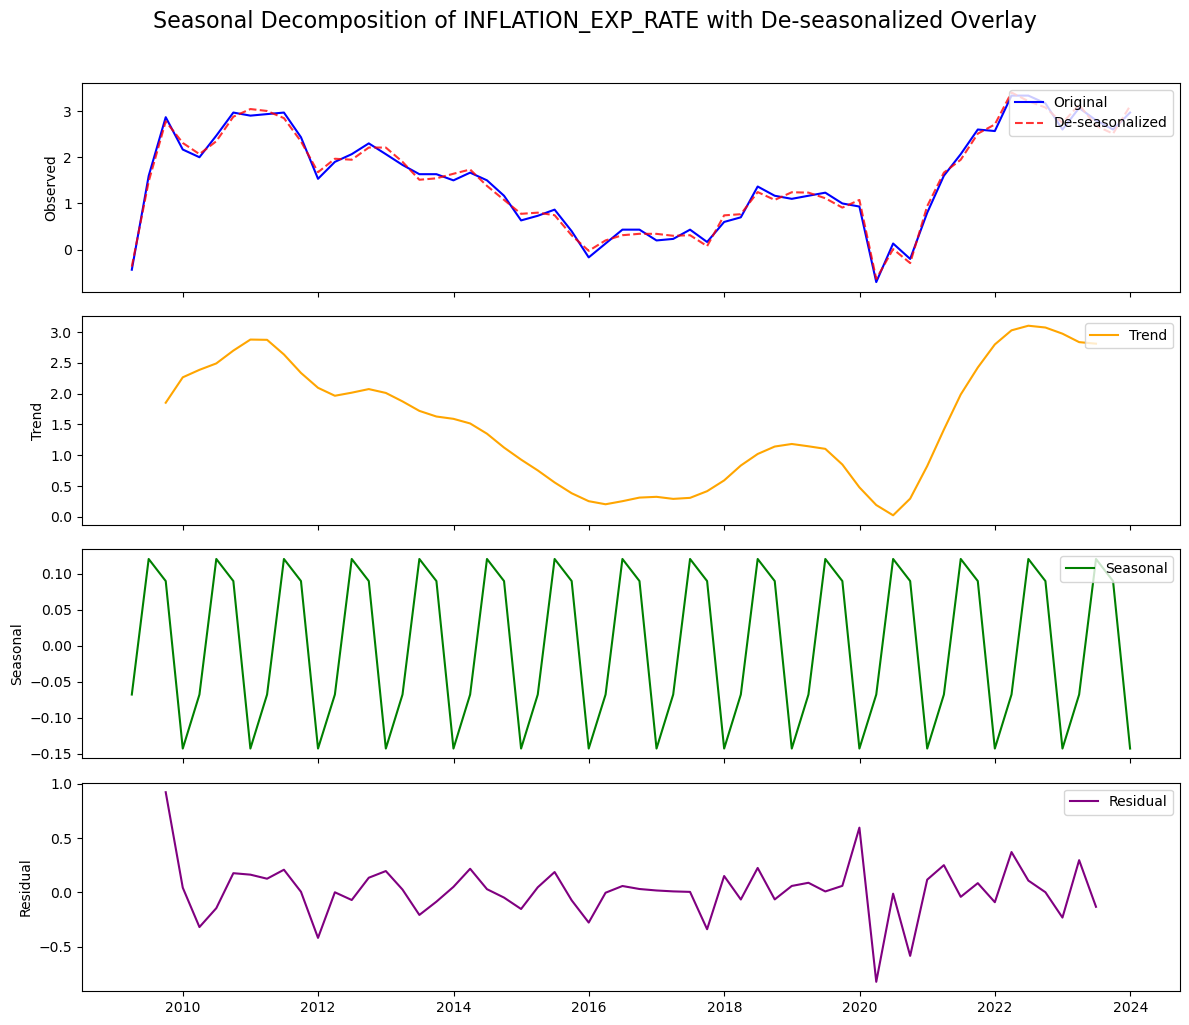

ADF Test for INFLATION_EXP_RATE:
  Test Statistic: -1.5901167588102865
  p-value: 0.48855628450881217
  Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
  INFLATION_EXP_RATE is not stationary. Applying first difference...


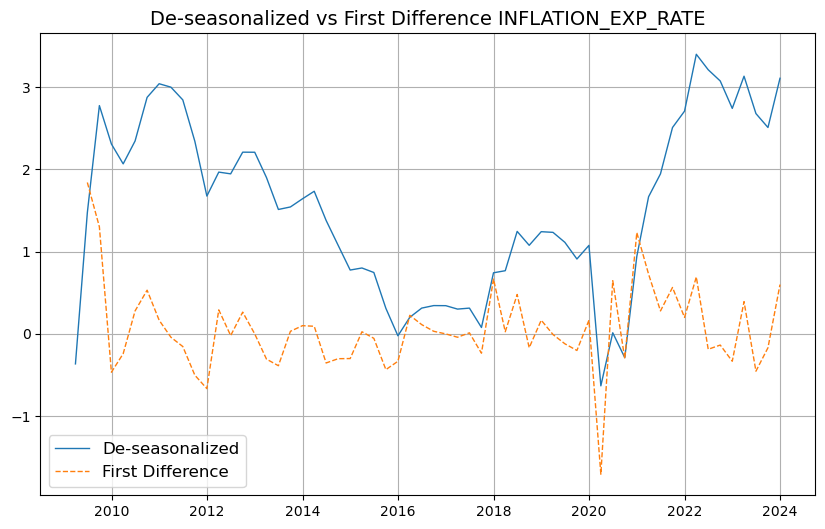

  ADF Test after differencing:
    Test Statistic: -6.162385552275379
    p-value: 7.12232131772811e-08
    Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}

--------------------------------------------------

Processing column: SOTE_INDEX_GROWTH_RATE


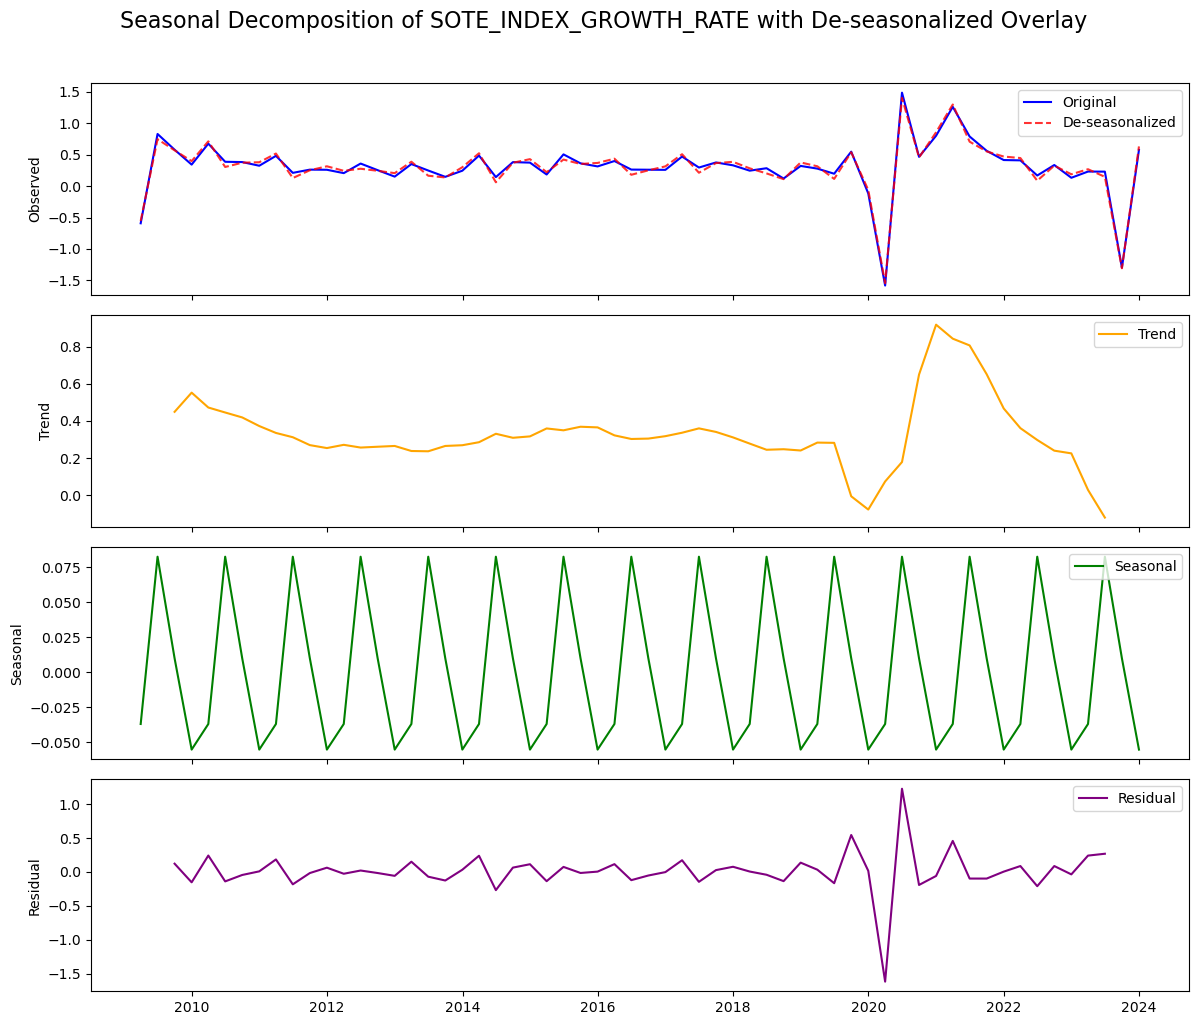

ADF Test for SOTE_INDEX_GROWTH_RATE:
  Test Statistic: -8.31604408194992
  p-value: 3.6785457935893493e-13
  Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
  SOTE_INDEX_GROWTH_RATE is stationary.

--------------------------------------------------

Processing column: GDP_FACT_VALUE


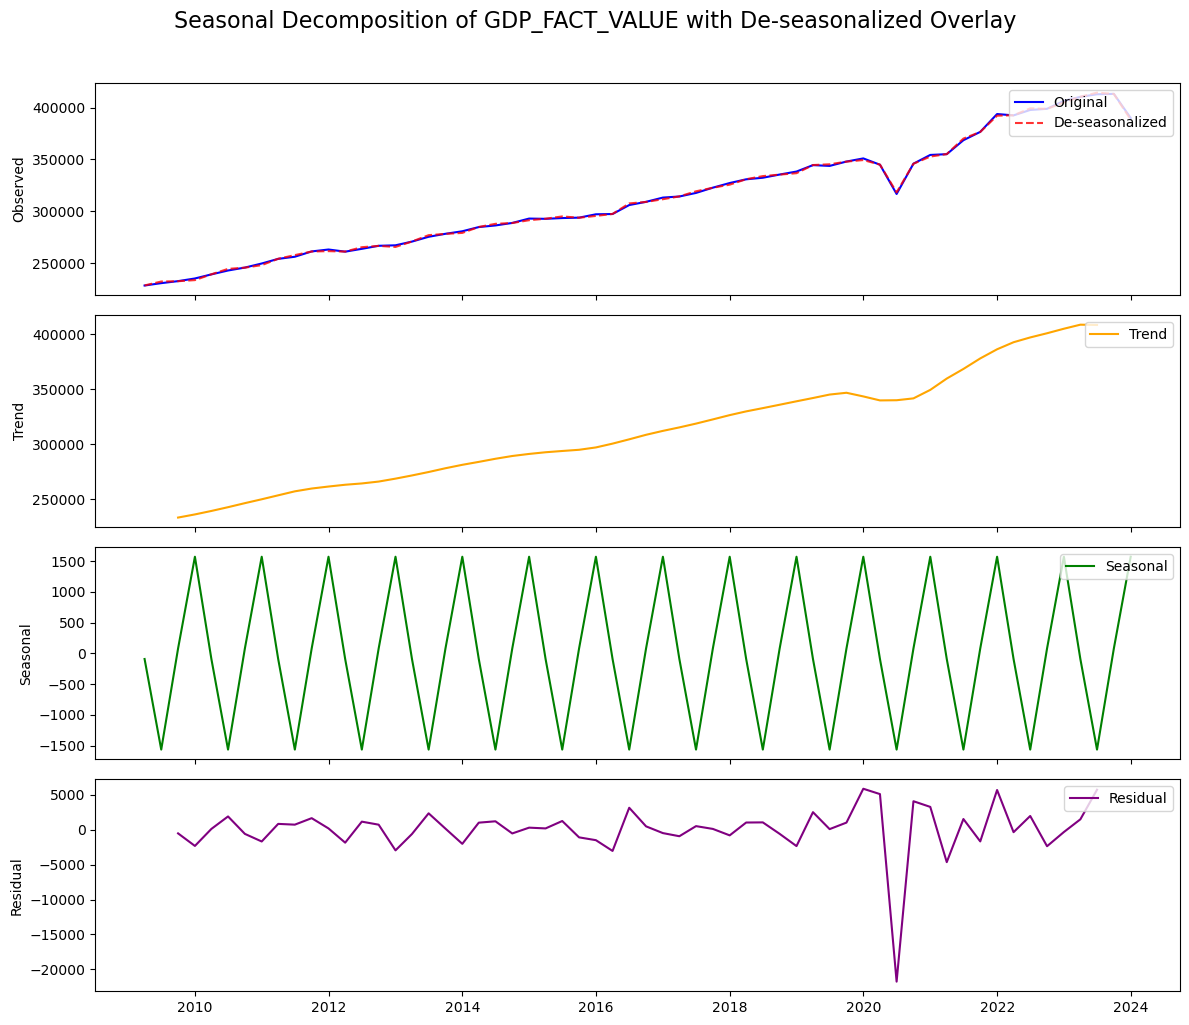

ADF Test for GDP_FACT_VALUE:
  Test Statistic: -0.7353876661599321
  p-value: 0.8373692063701619
  Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
  GDP_FACT_VALUE is not stationary. Applying first difference...


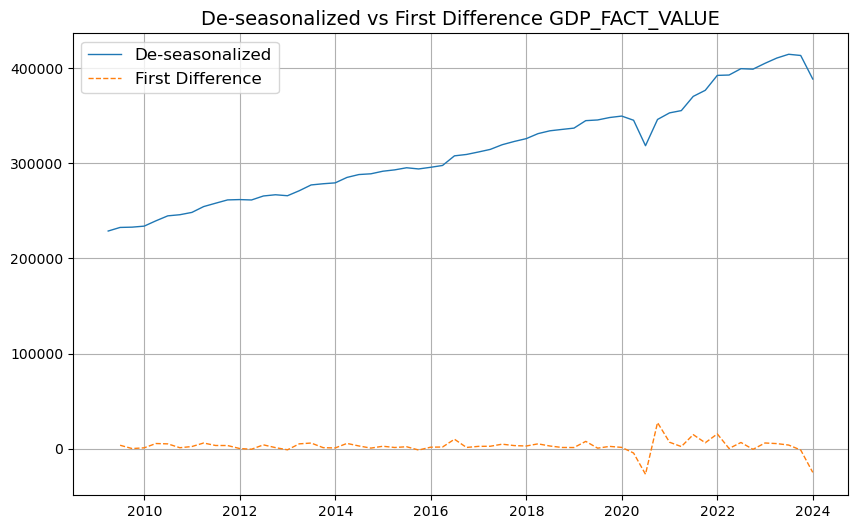

  ADF Test after differencing:
    Test Statistic: -7.339212917212369
    p-value: 1.0762214886476354e-10
    Critical Values: {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}

--------------------------------------------------

Processing column: GDP_GROWTH_RATE


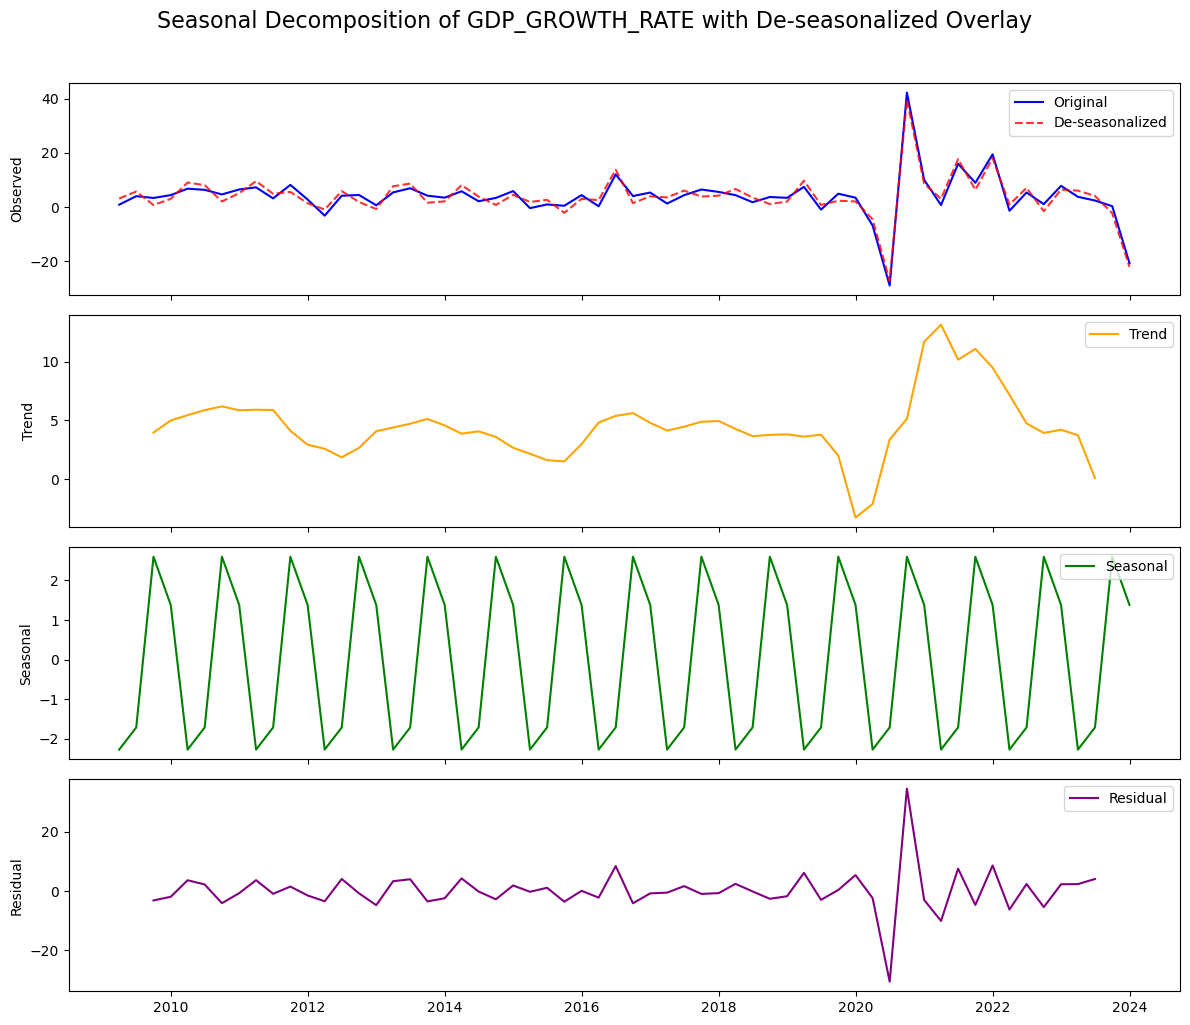

ADF Test for GDP_GROWTH_RATE:
  Test Statistic: -8.148033529397866
  p-value: 9.867059613894925e-13
  Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
  GDP_GROWTH_RATE is stationary.

--------------------------------------------------

Processing column: GAP_OF_OUTPUT


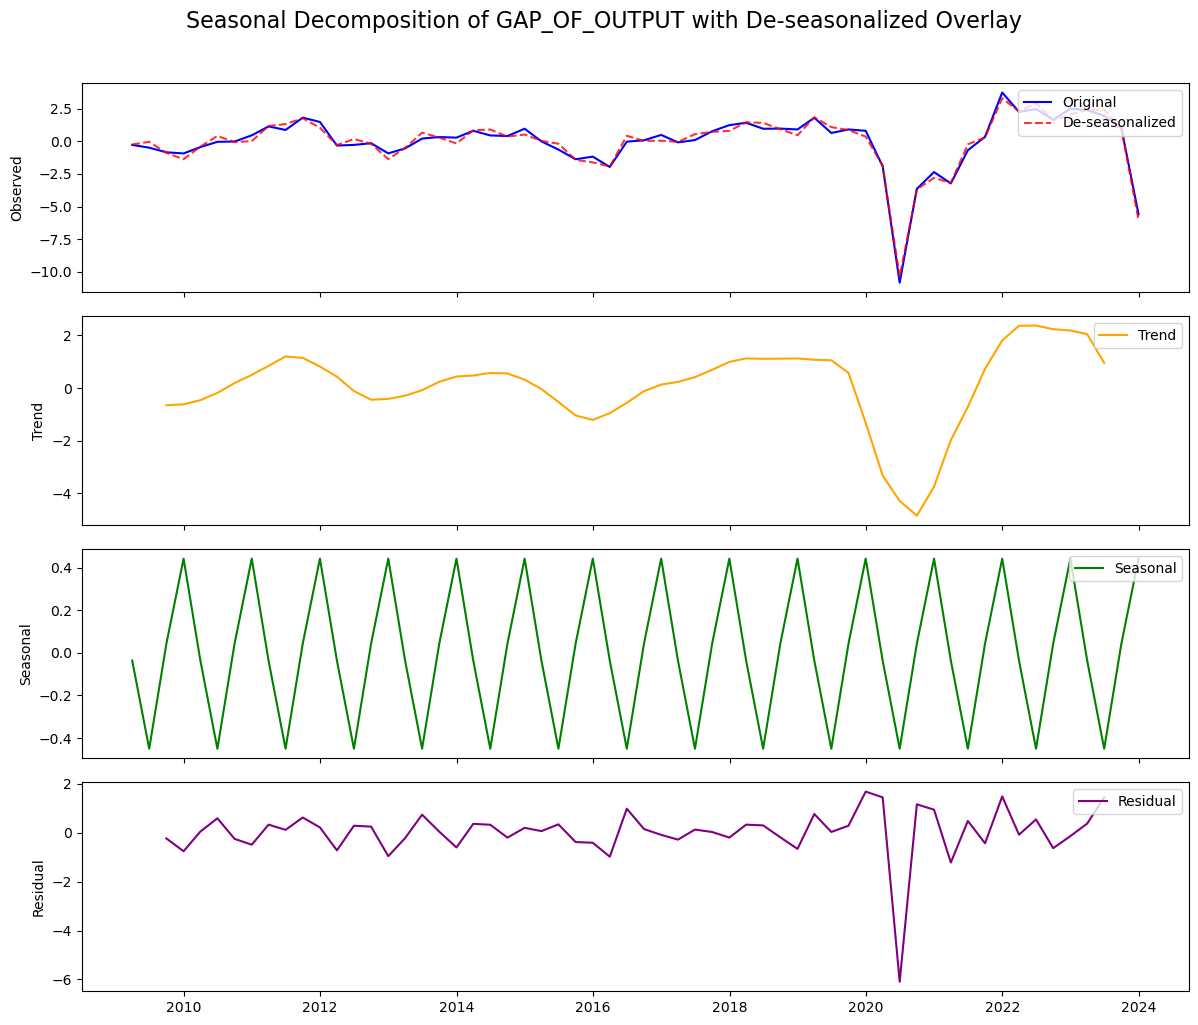

ADF Test for GAP_OF_OUTPUT:
  Test Statistic: -3.421291729241297
  p-value: 0.01025410165259773
  Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
  GAP_OF_OUTPUT is stationary.

--------------------------------------------------

Файл с очищенными данными успешно сохранён как 'data_non_seasonal.xlsx'


In [135]:
# Очистка данных от сезональности (№10 БОНУС)

data = pd.read_excel('data.xlsx')

df = data.copy()

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df = df.set_index('DATE')

time_series_data = df.select_dtypes(include=['float64', 'int64'])

time_series_data.head()

def analyze_and_transform(ts, column_name):
    result = seasonal_decompose(ts, model='additive', period=4)
    adjusted_series = ts - result.seasonal 
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Seasonal Decomposition of {column_name} with De-seasonalized Overlay", fontsize=16, y=1.02)
    
    axes[0].plot(result.observed, label='Original', color='blue')
    axes[0].plot(adjusted_series, label='De-seasonalized', linestyle='--', color='red', alpha=0.8)
    axes[0].legend(loc='upper right')
    axes[0].set_ylabel('Observed')
    
    axes[1].plot(result.trend, label='Trend', color='orange')
    axes[1].legend(loc='upper right')
    axes[1].set_ylabel('Trend')
    
    axes[2].plot(result.seasonal, label='Seasonal', color='green')
    axes[2].legend(loc='upper right')
    axes[2].set_ylabel('Seasonal')
    
    axes[3].plot(result.resid, label='Residual', color='purple')
    axes[3].legend(loc='upper right')
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()
    
    adf_result = adfuller(adjusted_series.dropna())

    print(f"ADF Test for {column_name}:")
    print(f"  Test Statistic: {adf_result[0]}")
    print(f"  p-value: {adf_result[1]}")
    print(f"  Critical Values: {adf_result[4]}")
    
    if adf_result[1] > 0.05:
        first_diff = adjusted_series.diff().dropna()
        
        plt.figure(figsize=(10, 6))
        plt.plot(adjusted_series, label='De-seasonalized', linewidth=1)
        plt.plot(first_diff, label='First Difference', linestyle='--', linewidth=1)
        plt.title(f"De-seasonalized vs First Difference {column_name}", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()
        
        adf_result_diff = adfuller(first_diff)
        print(f"  ADF Test after differencing:")
        print(f"    Test Statistic: {adf_result_diff[0]}")
        print(f"    p-value: {adf_result_diff[1]}")
        print(f"    Critical Values: {adf_result_diff[4]}")
        return first_diff
    else:
        print(f"  {column_name} и так стационарна.")
        return adjusted_series

transformed_series = {}

for column in time_series_data.columns:
    print(f"Processing column: {column}")
    transformed_series[column] = analyze_and_transform(time_series_data[column], column)
    print("\n" + "-"*50 + "\n")

transformed_df = pd.DataFrame(transformed_series)

transformed_df.to_excel('data_non_seasonal.xlsx')

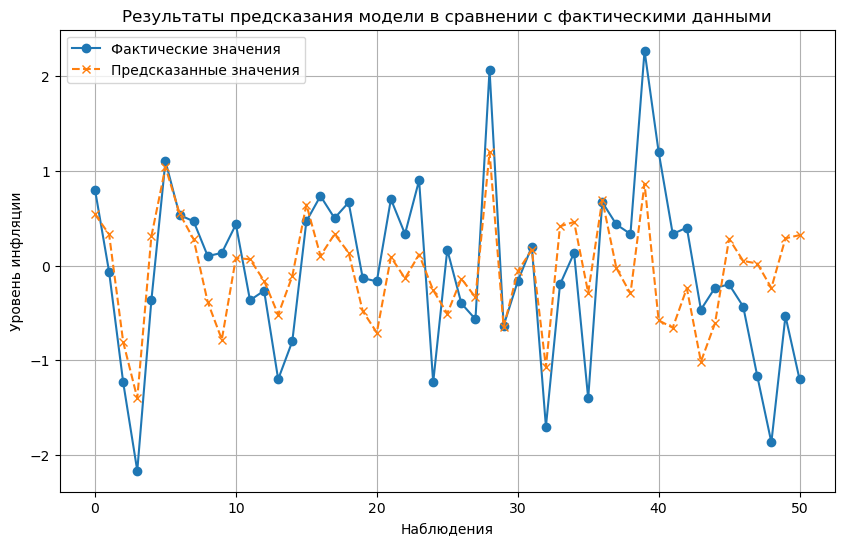

RMSE для спецификации 1: 0.7096604256078173
MAE для Спецификации 1: 0.5789871307855616


In [56]:
# Приступим к пересчету спецификаций с новым датасетом, который очищен от сезонности, код аналогичен:

# Спецификация 1 (HEADLINE) (№3)

data = pd.read_excel('data_non_seasonal.xlsx')
processed_data = data.copy()

num_lags = 4
lagged_columns = [f'lag_{i}' for i in range(1, num_lags + 1)]

for index, col_name in enumerate(lagged_columns, start=1):
    processed_data[col_name] = processed_data['HEADLINE_INFLATION_RATE'].shift(index)

processed_data['current'] = processed_data['HEADLINE_INFLATION_RATE']

for i in range(1, num_lags):
    processed_data[f'delta_{i}'] = (
        processed_data[lagged_columns[i - 1]] - processed_data[lagged_columns[i]]
    )

processed_data['delta_current'] = (
    processed_data['current'] - processed_data['lag_1']
)

forward_lag = 4
processed_data['future'] = processed_data['HEADLINE_INFLATION_RATE'].shift(-forward_lag)
processed_data['target'] = processed_data['future'] - processed_data['HEADLINE_INFLATION_RATE']

final_data = processed_data.dropna()

target_variable = final_data['target']
feature_columns = [col for col in final_data.columns if 'delta' in col]
features = final_data[feature_columns]

regression_model = sm.OLS(target_variable, sm.add_constant(features)).fit()
predicted_values = regression_model.predict(sm.add_constant(features))

rmse = mean_squared_error(target_variable, predicted_values) ** 0.5
mae = mean_absolute_error(target_variable, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(target_variable.values, label='Фактические значения', linestyle='-', marker='o')
plt.plot(predicted_values.values, label='Предсказанные значения', linestyle='--', marker='x')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid(True)
plt.show()

print(f'RMSE для спецификации 1: {rmse}')
print(f'MAE для Спецификации 1: {mae}')

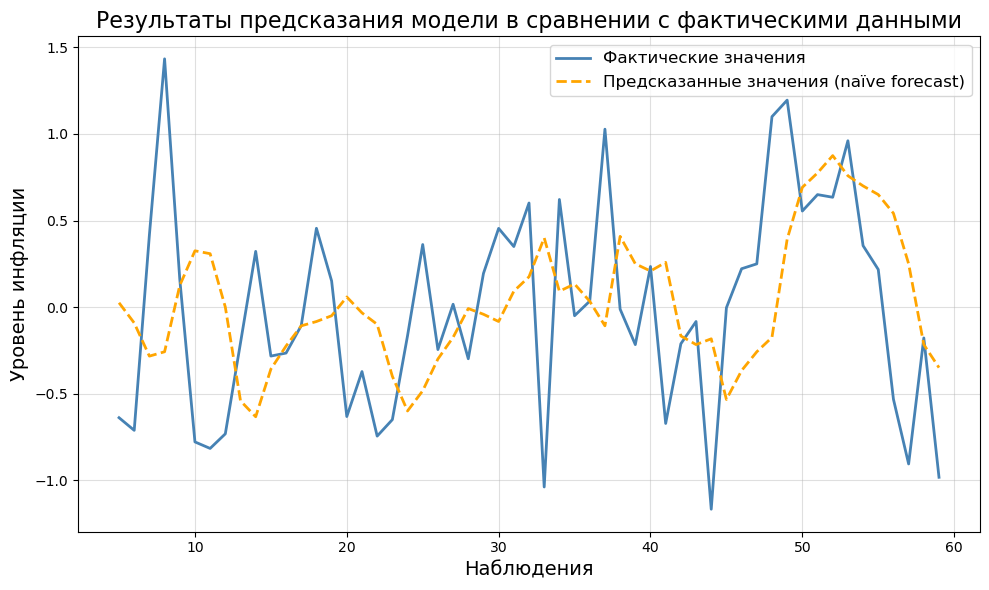

RMSE для прогнозной модели: 0.66
MAE для прогнозной модели: 0.52


In [138]:
# Спецификация 2 (HEADLINE) (№3) - naive forecast

df = pd.read_excel('data_non_seasonal.xlsx')

forecast_data = df[['HEADLINE_INFLATION_RATE']].copy()

forecast_data['forecast'] = forecast_data['HEADLINE_INFLATION_RATE'].rolling(4).mean().shift(1)

filtered_data = forecast_data.dropna()

actual_values = filtered_data['HEADLINE_INFLATION_RATE']
predicted_values = filtered_data['forecast']

rmse = (mean_squared_error(actual_values, predicted_values)) ** 0.5
mae = mean_absolute_error(actual_values, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(predicted_values, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'RMSE для прогнозной модели: {rmse:.2f}')
print(f'MAE для прогнозной модели: {mae:.2f}')

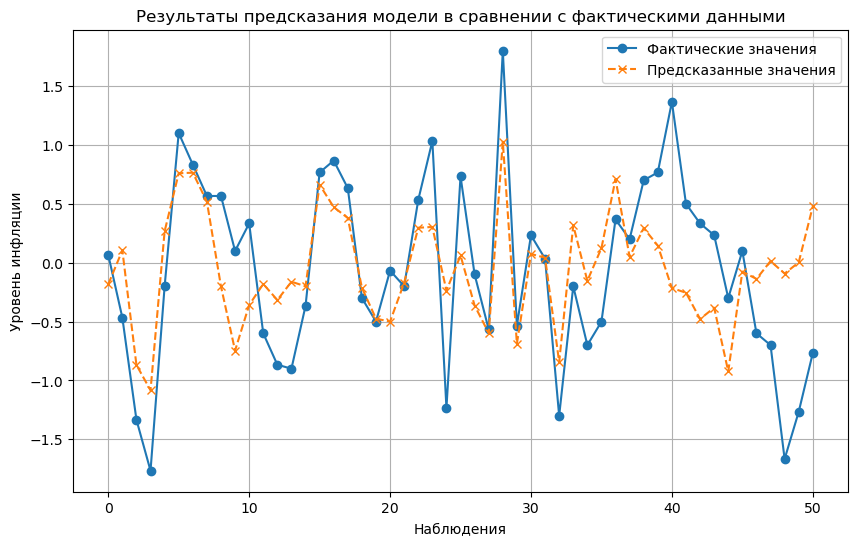

RMSE для спецификации 1 (CORE): 0.6289546955959822
MAE для Спецификации 1 (CORE): 0.5081686640595511


In [58]:
# Спецификация 1 (CORE_INFLATION) (№4)

data = pd.read_excel('data_non_seasonal.xlsx')
processed_data = data.copy()

num_lags = 4
lagged_columns = [f'lag_{i}' for i in range(1, num_lags + 1)]

for index, col_name in enumerate(lagged_columns, start=1):
    processed_data[col_name] = processed_data['CORE_INFLATION_RATE'].shift(index)

processed_data['current'] = processed_data['CORE_INFLATION_RATE']

for i in range(1, num_lags):
    processed_data[f'delta_{i}'] = (
        processed_data[lagged_columns[i - 1]] - processed_data[lagged_columns[i]]
    )

processed_data['delta_current'] = (
    processed_data['current'] - processed_data['lag_1']
)

forward_lag = 4
processed_data['future'] = processed_data['CORE_INFLATION_RATE'].shift(-forward_lag)
processed_data['target'] = processed_data['future'] - processed_data['CORE_INFLATION_RATE']

final_data = processed_data.dropna()

target_variable = final_data['target']
feature_columns = [col for col in final_data.columns if 'delta' in col]
features = final_data[feature_columns]

regression_model = sm.OLS(target_variable, sm.add_constant(features)).fit()
predicted_values = regression_model.predict(sm.add_constant(features))

rmse = mean_squared_error(target_variable, predicted_values) ** 0.5
mae = mean_absolute_error(target_variable, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(target_variable.values, label='Фактические значения', linestyle='-', marker='o')
plt.plot(predicted_values.values, label='Предсказанные значения', linestyle='--', marker='x')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid(True)
plt.show()

print(f'RMSE для спецификации 1 (CORE): {rmse}')
print(f'MAE для Спецификации 1 (CORE): {mae}')

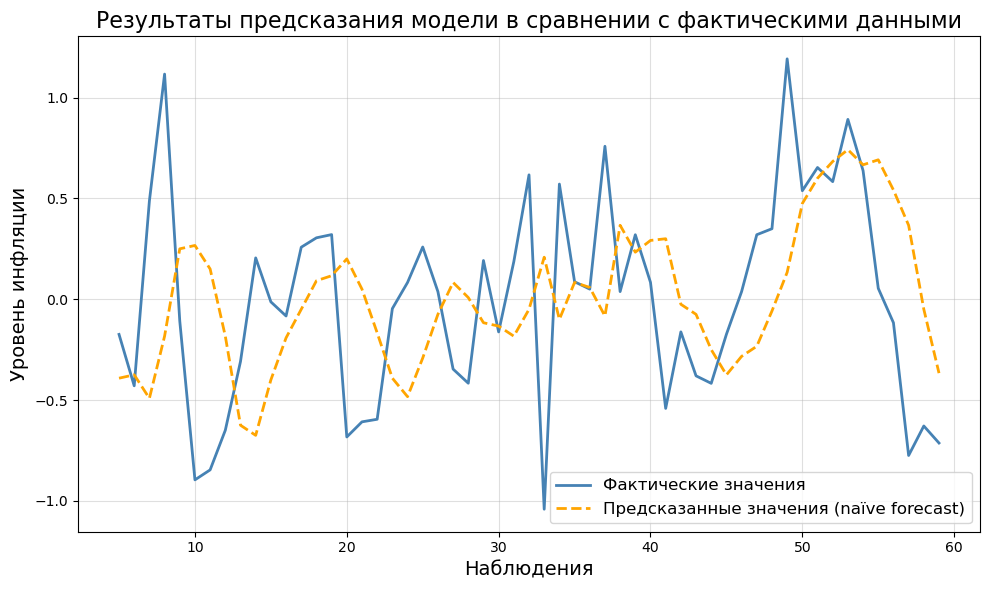

RMSE для Спецификации 2 (CORE): 0.5705997549820316
MAE для Спецификации 2 (CORE): 0.45227140762487883


In [140]:
# Спецификация 2 (CORE_INFLATION) (№4) - naive forecast

df = pd.read_excel('data_non_seasonal.xlsx')

forecast_data = df[['CORE_INFLATION_RATE']].copy()

forecast_data['forecast'] = forecast_data['CORE_INFLATION_RATE'].rolling(4).mean().shift(1)

filtered_data = forecast_data.dropna()

actual_values = filtered_data['CORE_INFLATION_RATE']
predicted_values = filtered_data['forecast']

naive_rmse = (mean_squared_error(actual_values, predicted_values)) ** 0.5
naive_mae = mean_absolute_error(actual_values, predicted_values)

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(predicted_values, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 2 (CORE): {naive_rmse}')
print(f'MAE для Спецификации 2 (CORE): {naive_mae}')

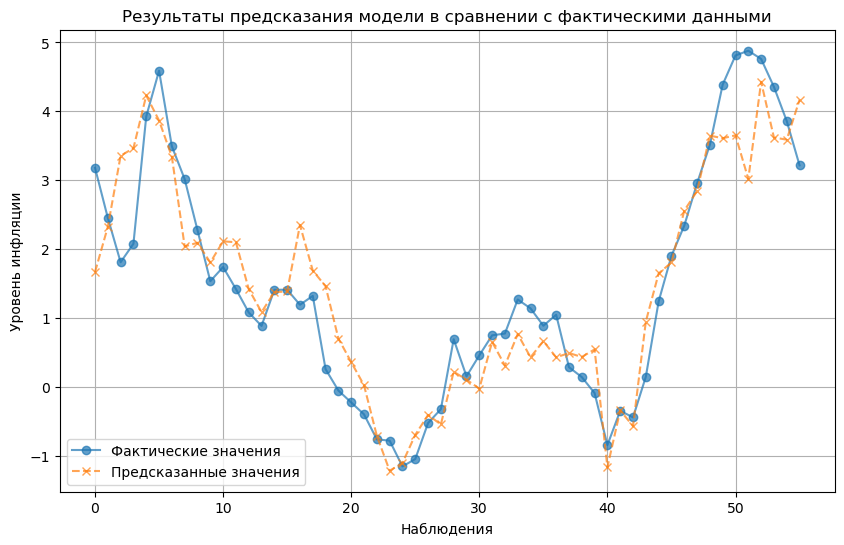

RMSE для Спецификации 3: 0.6534
MAE для Спецификации 3: 0.4928


In [61]:
# Спецификация 3 (№5) - в данном случае мы использовали значения зависимой и незаввисимой переменных,
# рассчитанные "вручную" в Excel

df_spec3 = pd.read_excel('spec3_gretl_non_seasonal.xlsx')

y_spec3 = df_spec3['pi_(t+4)']
X_spec3 = df_spec3[['pie_t+4']]

if not y_spec3.index.equals(X_spec3.index):
    common_index = y_spec3.index.intersection(X_spec3.index)
    y_spec3 = y_spec3.loc[common_index]
    X_spec3 = X_spec3.loc[common_index]

if y_spec3.isnull().any() or X_spec3.isnull().any().any():
    print("Обнаружены пропущенные значения. Удаляем их...")
    y_spec3 = y_spec3.dropna()
    X_spec3 = X_spec3.dropna()

X_with_const = sm.add_constant(X_spec3)

model = sm.OLS(y_spec3, X_with_const)
results = model.fit()

y_pred_spec3 = results.predict(X_with_const)

rmse = np.sqrt(mean_squared_error(y_spec3, y_pred_spec3))
mae = mean_absolute_error(y_spec3, y_pred_spec3)

plt.figure(figsize=(10, 6))
plt.plot(y_spec3.values, label='Фактические значения', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_spec3, label='Предсказанные значения', marker='x', linestyle='--', alpha=0.7)
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.legend()
plt.grid()
plt.show()

print(f'RMSE для Спецификации 3: {rmse:.4f}')
print(f'MAE для Спецификации 3: {mae:.4f}')

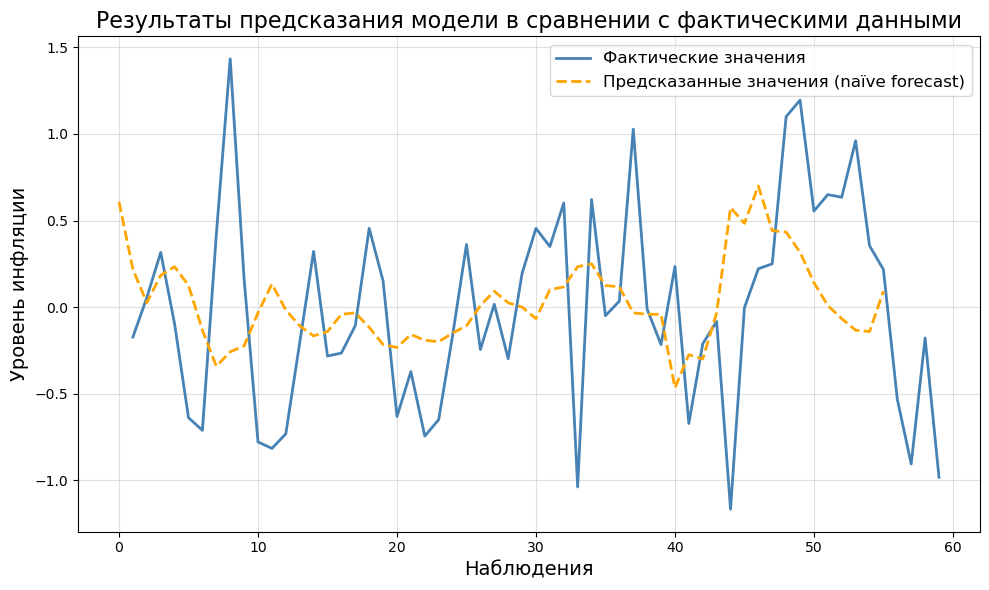

R^2 (Коэффициент детерминации): -0.1444
RMSE (Среднеквадратичная ошибка): 0.6055
MAE (Средняя абсолютная ошибка): 0.4721
F-статистика: -6.6863


In [62]:
# Спецификация 4 (№5) - naive forecast

df_original = pd.read_excel('data_non_seasonal.xlsx')

df = df_original.copy()

df['ROLLING_INFL_EXP_GROWTH'] = df['INFLATION_EXP_RATE'].rolling(window=4).mean()
df['HEADLINE_INFLATION_FORECAST'] = df['ROLLING_INFL_EXP_GROWTH'].shift(-4)

actual = df['HEADLINE_INFLATION_RATE']
forecast = df['HEADLINE_INFLATION_FORECAST']

aligned_data = pd.DataFrame({
    "actual": actual,
    "forecast": forecast
}).dropna()

aligned_actual = aligned_data['actual']
aligned_forecast = aligned_data['forecast']

mae = mean_absolute_error(aligned_actual, aligned_forecast)
rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))
r2 = r2_score(aligned_actual, aligned_forecast)

rss = np.sum((aligned_actual - aligned_forecast) ** 2)
tss = np.sum((aligned_actual - aligned_actual.mean()) ** 2)
f_stat = ((tss - rss) / 1) / (rss / (len(aligned_actual) - 2))

plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Фактические значения', linewidth=2, color='steelblue')
plt.plot(forecast.index, forecast, label='Предсказанные значения (naïve forecast)', linestyle='--', linewidth=2, color='orange')
plt.title('Результаты предсказания модели в сравнении с фактическими данными', fontsize=16)
plt.xlabel('Наблюдения', fontsize=14)
plt.ylabel('Уровень инфляции', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f'R^2 (Коэффициент детерминации): {r2:.4f}')
print(f'RMSE (Среднеквадратичная ошибка): {rmse:.4f}')
print(f'MAE (Средняя абсолютная ошибка): {mae:.4f}')
print(f'F-статистика: {f_stat:.4f}')

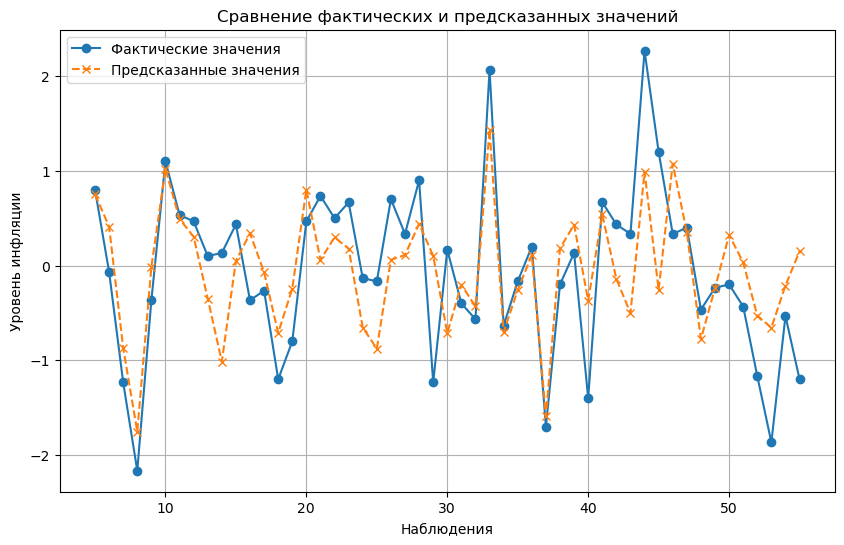

R^2 (Коэффициент детерминации): 0.5078
RMSE (Среднеквадратичная ошибка): 0.6235
MAE (Средняя абсолютная ошибка): 0.4954
F-статистика: 9.2867


In [65]:
# Спецификация 5 (№6)

original_df = pd.read_excel('data_non_seasonal.xlsx')

df = original_df.copy()

df['pi_t'] = df['HEADLINE_INFLATION_RATE']
df['pi_t-1'] = df['pi_t'].shift(1)
df['pi_t-2'] = df['pi_t'].shift(2)
df['pi_t-3'] = df['pi_t'].shift(3)
df['pi_t-4'] = df['pi_t'].shift(4)

df['pi_t - pi_t-1'] = df['pi_t'] - df['pi_t-1']
df['pi_t-1 - pi_t-2'] = df['pi_t-1'] - df['pi_t-2']
df['pi_t-2 - pi_t-3'] = df['pi_t-2'] - df['pi_t-3']
df['pi_t-3 - pi_t-4'] = df['pi_t-3'] - df['pi_t-4']

df['xt-1'] = df['GAP_OF_OUTPUT'].shift(1)

df_clean = df.dropna()

df_clean['pi_t+4'] = df_clean['pi_t'].shift(-4)
df_clean['pi_t+4 - pi_t'] = df_clean['pi_t+4'] - df_clean['pi_t']

df_clean = df_clean.dropna(subset=['pi_t+4 - pi_t'])

X = df_clean[['pi_t - pi_t-1', 'pi_t-1 - pi_t-2', 'pi_t-2 - pi_t-3', 'pi_t-3 - pi_t-4', 'xt-1']]
y = df_clean['pi_t+4 - pi_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

r_squared = results.rsquared
rmse = np.sqrt(mean_squared_error(y, results.fittedvalues))
mae = mean_absolute_error(y, results.fittedvalues)
f_stat = results.fvalue

y_actual = y
y_predicted = results.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Фактические значения', marker='o', linestyle='-')
plt.plot(y_actual.index, y_predicted, label='Предсказанные значения', marker='x', linestyle='--')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

print(f'R^2 (Коэффициент детерминации): {r_squared:.4f}')
print(f'RMSE (Среднеквадратичная ошибка): {rmse:.4f}')
print(f'MAE (Средняя абсолютная ошибка): {mae:.4f}')
print(f'F-статистика: {f_stat:.4f}')

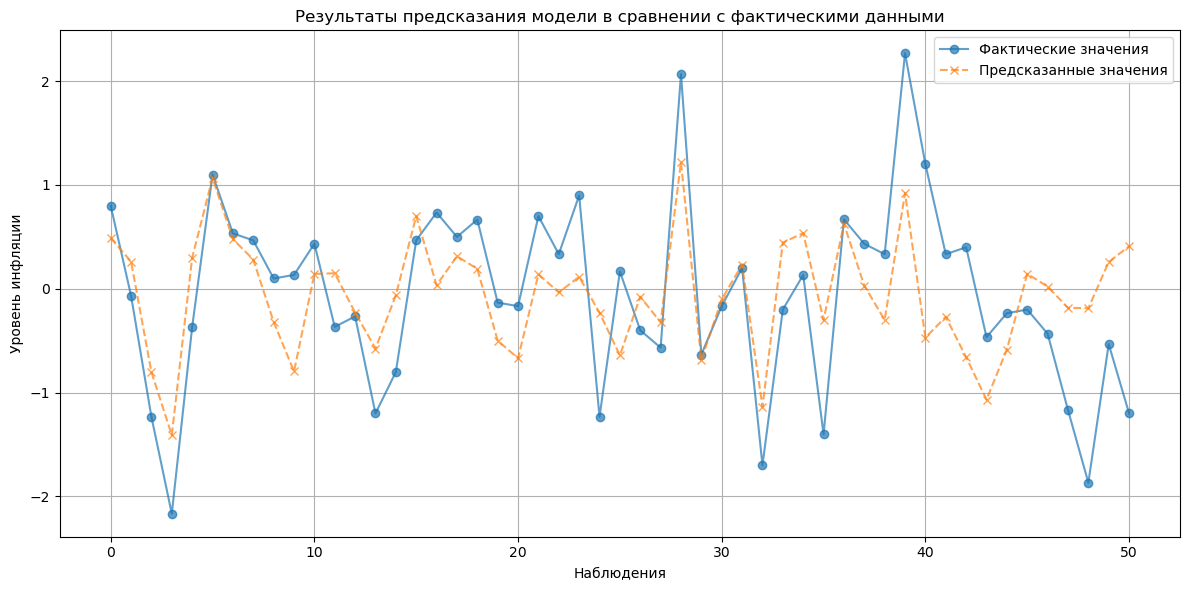

RMSE для Спецификации 6: 0.7023
MAE для Спецификации 6: 0.5717


In [66]:
# Спецификация 6 (№6)

df = pd.read_excel('data_non_seasonal.xlsx')

df_copy = df.copy()

df_copy['pi_t'] = df_copy['HEADLINE_INFLATION_RATE']
df_copy['pi_t+4'] = df_copy['pi_t'].shift(-4)
df_copy['pi_t-1'] = df_copy['pi_t'].shift(1)
df_copy['pi_t-2'] = df_copy['pi_t'].shift(2)
df_copy['pi_t-3'] = df_copy['pi_t'].shift(3)
df_copy['pi_t-4'] = df_copy['pi_t'].shift(4)

df_copy['pi_t+4_minus_pi_t'] = df_copy['pi_t+4'] - df_copy['pi_t']
df_copy['pi_t_minus_pi_t-1'] = df_copy['pi_t'] - df_copy['pi_t-1']
df_copy['pi_t-1_minus_pi_t-2'] = df_copy['pi_t-1'] - df_copy['pi_t-2']
df_copy['pi_t-2_minus_pi_t-3'] = df_copy['pi_t-2'] - df_copy['pi_t-3']
df_copy['pi_t-3_minus_pi_t-4'] = df_copy['pi_t-3'] - df_copy['pi_t-4']

df_copy['x_t-1'] = df_copy['GDP_GROWTH_RATE'].shift(1)

regression_data = df_copy[['pi_t+4_minus_pi_t', 'pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                           'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']].dropna()

y = regression_data['pi_t+4_minus_pi_t']
X = regression_data[['pi_t_minus_pi_t-1', 'pi_t-1_minus_pi_t-2',
                     'pi_t-2_minus_pi_t-3', 'pi_t-3_minus_pi_t-4', 'x_t-1']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

y_pred = model.predict(X)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
mae = np.mean(np.abs(y - y_pred))

plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y.values, label='Фактические значения', marker='o', linestyle='-', alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label='Предсказанные значения', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Результаты предсказания модели в сравнении с фактическими данными')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f'RMSE для Спецификации 6: {rmse:.4f}')
print(f'MAE для Спецификации 6: {mae:.4f}')

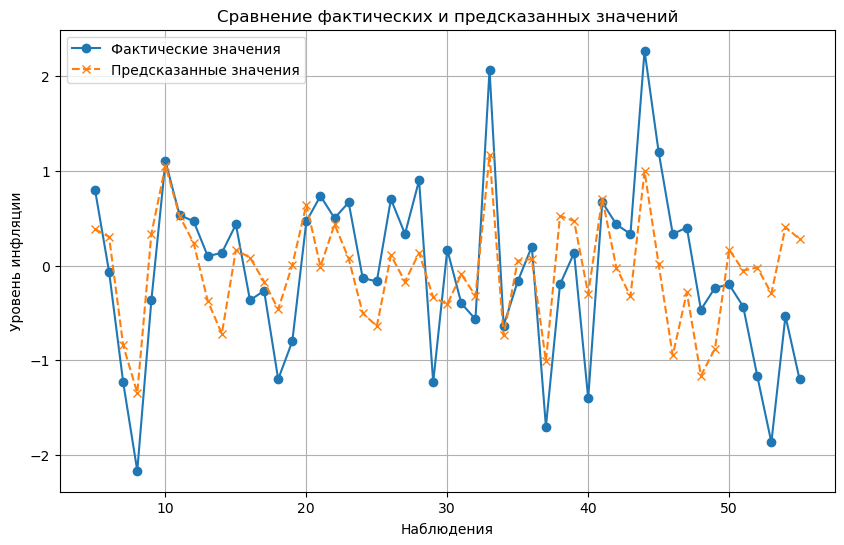

R^2 (Коэффициент детерминации): 0.3812
RMSE (Среднеквадратичная ошибка): 0.6992
MAE (Средняя абсолютная ошибка): 0.5881
F-статистика: 5.5443


In [67]:
# Спецификация 7 (№ 6)

original_df = pd.read_excel('data_non_seasonal.xlsx')

df = original_df.copy()

df['pi_t'] = df['HEADLINE_INFLATION_RATE']
df['pi_t-1'] = df['pi_t'].shift(1)
df['pi_t-2'] = df['pi_t'].shift(2)
df['pi_t-3'] = df['pi_t'].shift(3)
df['pi_t-4'] = df['pi_t'].shift(4)

df['pi_t - pi_t-1'] = df['pi_t'] - df['pi_t-1']
df['pi_t-1 - pi_t-2'] = df['pi_t-1'] - df['pi_t-2']
df['pi_t-2 - pi_t-3'] = df['pi_t-2'] - df['pi_t-3']
df['pi_t-3 - pi_t-4'] = df['pi_t-3'] - df['pi_t-4']

df['xt-1'] = df['SOTE_INDEX_GROWTH_RATE'].shift(1)

df_clean = df.dropna()

df_clean['pi_t+4'] = df_clean['pi_t'].shift(-4)
df_clean['pi_t+4 - pi_t'] = df_clean['pi_t+4'] - df_clean['pi_t']

df_clean = df_clean.dropna(subset=['pi_t+4 - pi_t'])

X = df_clean[['pi_t - pi_t-1', 'pi_t-1 - pi_t-2', 'pi_t-2 - pi_t-3', 'pi_t-3 - pi_t-4', 'xt-1']]
y = df_clean['pi_t+4 - pi_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

r_squared = results.rsquared
rmse = np.sqrt(mean_squared_error(y, results.fittedvalues))
mae = mean_absolute_error(y, results.fittedvalues)
f_stat = results.fvalue

y_actual = y
y_predicted = results.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Фактические значения', marker='o', linestyle='-')
plt.plot(y_actual.index, y_predicted, label='Предсказанные значения', marker='x', linestyle='--')
plt.xlabel('Наблюдения')
plt.ylabel('Уровень инфляции')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

print(f'R^2 (Коэффициент детерминации): {r_squared:.4f}')
print(f'RMSE (Среднеквадратичная ошибка): {rmse:.4f}')
print(f'MAE (Средняя абсолютная ошибка): {mae:.4f}')
print(f'F-статистика: {f_stat:.4f}')

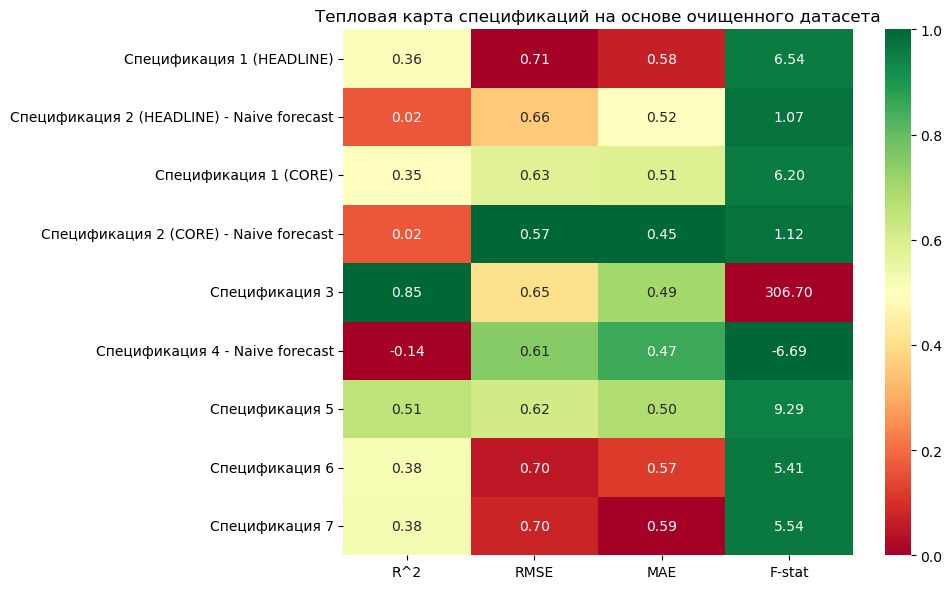

In [29]:
# Сравнительный анализ спецификаций (№7)

data = {
    "Specification": [
        "Спецификация 1 (HEADLINE)",
        "Спецификация 2 (HEADLINE) - Naive forecast",
        "Спецификация 1 (CORE)",
        "Спецификация 2 (CORE) - Naive forecast",
        "Спецификация 3",
        "Спецификация 4 - Naive forecast",
        "Спецификация 5",
        "Спецификация 6",
        "Спецификация 7",
    ],
    "R^2": [0.362, 0.0198,  0.350, 0.0206, 0.850, -0.1444, 0.508, 0.376, 0.3812],
    "RMSE": [
         0.7096604256078173,
        0.66,
        0.6289546955959822,
        0.5705997549820316,
        0.6534,
        0.6055,
        0.624,
        0.7023,
        0.699160,
    ],
    "MAE": [
        0.5789871307855616,
        0.52,
        0.5081686640595511,
        0.45227140762487883,
        0.4928,
        0.4721,
        0.4953,
        0.5717,
        0.58808,
    ],
    "F-stat": [6.539, 1.073, 6.202, 1.117, 306.7, -6.6863, 9.29, 5.414, 5.544],
}

df = pd.DataFrame(data)

normalized_df = df.drop(columns=["Specification"])
normalized_df = (normalized_df - normalized_df.min()) / (normalized_df.max() - normalized_df.min())

adjusted_df = normalized_df.copy()
adjusted_df["RMSE"] = 1 - normalized_df["RMSE"]
adjusted_df["MAE"] = 1 - normalized_df["MAE"]
adjusted_df["F-stat"] = 1 - normalized_df["F-stat"]

plt.figure(figsize=(10, 6))
sns.heatmap(adjusted_df, annot=df.drop(columns=["Specification"]), cmap="RdYlGn", cbar=True, fmt=".2f")
plt.title("Тепловая карта спецификаций на основе очищенного датасета")
plt.yticks(np.arange(len(df)) + 0.5, df["Specification"], rotation=0)
plt.tight_layout()
plt.show()
plt.show()

**Спасибо за внимание!**

Надеемся, было интересно
:)